In [74]:
#v10


In [75]:
from IPython.display import HTML
from vevestaX import vevesta as v
from IPython.display import display, HTML
from PIL import Image
from dask.distributed import Client
from dask.distributed import as_completed
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter
from pandas.io.formats.style import Styler
from pivottablejs import pivot_ui
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import re
from statsmodels.stats.outliers_influence import summary_table
import datetime as dt
import matplotlib
import matplotlib as mp
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_market_calendars as mcal
import pickle
import rpy2
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import statsmodels
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
import rpy2
import rpy2.robjects as ro
import time
from clustergram import Clustergram
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.vq import vq
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import scale
from k_means_constrained import KMeansConstrained
from scipy.stats import f
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML as html_print
from IPython.display import display


pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

import pandas as pd
from rpy2.robjects import pandas2ri
from prophet import Prophet

In [76]:
#if not sys.warnoptions:
#    import warnings
#    warnings.simplefilter("ignore")

wd = os.getcwd()

if (os.defpath==".;C:\\bin"):
    os.environ['R_HOME'] = 'C:/Users/User/Documents/R/R-4.1.2'
    os.environ['R_LIBS'] = 'C:/Users/User/Documents/R/R-4.1.2/library'
    from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
else:
    os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'

pandas2ri.activate()


In [77]:

#robjects.ro['version']

base = importr('base')
#grdevices = importr('grDevices')
print(base._libPaths())

timetk = importr('timetk')
magrittr = importr('magrittr')
dplyr = importr('dplyr')
tidyverse = importr('tidyverse')
nbclust = importr('NbClust')
grdevices = importr('grDevices')


[1] "C:/Users/User/Documents/R/R-4.1.2/library"



In [78]:
si = ['03-31','06-30','09-30','12-31']
               
[start,end,prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted, dict_sectors, dict_indexes, dict_sectors_reverse, invert_dict_indexes, list_sector_n_indexes, list_stocks] = pickle.load(open('..\\data\\interim\\data_object.pkl', 'rb'))

fred_friendly_names = ['Consumer Loans','Copper','Iron and Steel','Gold','Unemployment','Market volatility','Commercial-Industrial Loans','Average Weekly Hours','Credit to Income','Consumer Confidence','Oil Prices','Inflation','Housing Prices','Interest Rates','10 Year to 3 Month','Recession Indicator','OECD Leading Indicator','Coincident Index','Index: Industrial Production','Mfr Orders Excl AC','Personal Expenditures',]
fred_names = ['CONSUMER','WPUSI019011','WPU101','GVZCLS','UNRATE','VIXCLS','BUSLOANS','AWHAETP','UMCSENT','TDSP','DCOILWTICO','CPIAUCSL','CSUSHPINSA','FEDFUNDS','T10Y3M','USREC','USALOLITONOSTSAM','USPHCI','INDPRO','NEWORDER','PCE']

dict_fred = dict(zip(*[fred_names,fred_friendly_names]))

nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

fundamentals_quarterlies = pickle.load(open('..\\data\\interim\\fundamental.pkl', 'rb'))
fundamental_entries = [e[0] for e in fundamentals_quarterlies]

sectors.columns = ['Symbol']
indexes.columns = ['Symbol']

newDates = pd.date_range((end+ dt.timedelta(7)).strftime('%Y-%m-%d'), (end + dt.timedelta(92)).strftime('%Y-%m-%d'), freq='W-'+nyse_dates.index[-1].strftime('%a')).map(lambda t: t.strftime('%Y-%m-%d'))


In [79]:
#completed_fred_pvt_df = completed_fred_pvt.asfreq('D').reindex(nyse_dates.index).interpolate(method='time')
completed_fred_pvt_df = completed_fred_pvt

temp_new = completed_fred_pvt.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates.index)
temp_dates = pd.date_range(completed_fred_pvt.index[0].strftime('%Y-%m-%d'), completed_fred_pvt.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
nyse_inbetween_temp_dates = nyse_dates.index[(nyse_dates.index >= temp_dates[0]) & (nyse_dates.index <= temp_dates[-1])]
temp_new = temp_new.reindex(nyse_inbetween_temp_dates)

completed_fred_pvt_df = temp_new
completed_fred_pvt_df.columns = [name[1] for name in completed_fred_pvt_df.columns]

np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))]

array(['2017-03-16', '2017-09-26', '2018-04-10', '2018-10-18',
       '2019-05-03', '2019-11-12', '2020-05-27', '2020-12-04',
       '2021-06-18', '2021-12-29', '2022-07-12'], dtype=object)

In [80]:
n_ahead = 13

cv_inner = TimeSeriesSplit(n_splits=10,test_size=n_ahead)
cv_outer = TimeSeriesSplit(n_splits=11,test_size=n_ahead)


In [81]:

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

def print_color(t):
    print(t)
    display(html_print(' '.join([cstr(ti, color=ci) for ti,ci in t])))


In [82]:
def findknee(xdata):
    rate_of_change=(xdata[0]-xdata[-1])/(len(xdata)-1)
    #print(rate_of_change)
    delta = xdata-xdata[-1]
    deltas = []
    deltas.append(delta[0])
    for d in range(1,len(xdata)):
        deltas.append(deltas[d-1]-rate_of_change)
    #print(deltas)
    for d in range(0,len(xdata)):
        deltas[d]=delta[d]-deltas[d]
    return(np.round(np.abs(deltas)))

def deriveANOVA(clf, df):

    labels = clf.labels_
    clusters = clf.n_clusters
    centers = clf.cluster_centers_
        
    within_ss = []

    for n in range(0,clusters):
      #WSS means the sum of distances between the points and the corresponding centroids for each cluster
      data = df[labels==(n)]
      within_ss.append(((data - centers[n])**2).sum(1).sum())

    WSS = total_within_ss = np.sum(within_ss)

    print('wss',total_within_ss)

    #sum of ((deviation from variable means) squared)
    tot_ss = np.sum(np.sum((df-df.mean())**2))
    print('tot_ss',tot_ss)

    cluster_BSS = []
    for n in range(0,clusters):
      #sum((variable/column means cluster - variable/column means data)^2)*len(cluster members)
      BSS = np.sum((df[labels==(n)].mean()-np.array(np.mean(df)))**2)*len(df[labels==(n)])
      cluster_BSS.append(BSS)

    BSS = np.sum(cluster_BSS)
    print('bss',BSS)
    
    return(tot_ss, BSS, within_ss)

def findOptimalK_ANOVA(df, mink=2, maxk=6, init_min=2, init_max=5):

    tss = []
    bss = []
    wss = []

    for k in range(mink,maxk):
        print(k)

        print(max(init_min,k+1))
        size_min_ = max(init_min,k+1)
        size_max_ = max(np.ceil(len(df)/k),init_max)
        if(size_min_>size_max_):
            break
        else:
            clf = KMeansConstrained(n_clusters=k, size_min=size_min_, size_max=size_max_, init='k-means++', n_init=100, max_iter=100, tol=0.0001, verbose=False, random_state=int(time.time()), copy_x=True, n_jobs=4)
            clf.fit_predict(np.array(df))

            tot_ss, BSS, within_ss = deriveANOVA(clf, df)

            wss.append(within_ss)
            tss.append(tot_ss)
            bss.append(BSS)

    return(tss, bss, wss)

In [83]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total


In [84]:
def highlight_cells(val, color_if_true, color_if_false, threshold_):
    color = color_if_true if val >= threshold_ else color_if_false
    return 'background-color: {}'.format(color)

In [85]:
def derive_fb_test_error(npa):
    n_ahead = 13

    subset_train = npa[0]
    subset_test = npa[1]

    base_model = Prophet()

    prophet_df_base = subset_train['Adj Close'].reset_index()#data.reset_index()
    prophet_df_base.columns = ['ds','y']
    prophet_df_base['y'] = np.log(prophet_df_base['y'])

    base_model.fit(prophet_df_base)

    future_base = base_model.make_future_dataframe(periods = n_ahead,freq='W-'+subset_train.index[-1].strftime('%a'))

    forecast_base = base_model.predict(future_base).set_index('ds')[['yhat','yhat_lower','yhat_upper']]
    df_pred_base = np.exp(forecast_base)

    rmse_ = mean_squared_error(subset_test['Adj Close'].tail(n_ahead), df_pred_base['yhat'].tail(n_ahead), squared=True)
    return([[subset_test['Adj Close'].tail(n_ahead)],[df_pred_base['yhat'].tail(n_ahead)],rmse_])

In [86]:
"""
symbol_ = 'BA'

if(str(symbol_)=='None'):
    run=False
else:
    run=True

if(run):
    client = Client('192.168.3.100:8786')
    #client = Client(n_workers=4,threads_per_worker=1)

    s = symbol_
    msize = 2
    date_form = DateFormatter("%Y-%m-%d")

    metrics_df_ = pd.DataFrame(pd.DataFrame(screener_sorted.loc[s]).T[['volume_factor','Adj Close','adf','hurst']])
    subset=prices_df[prices_df['Symbol']==s]
    
    y = subset['Adj Close']
    data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W-'+subset.index[-1].strftime('%a'))
"""

'\nsymbol_ = \'BA\'\n\nif(str(symbol_)==\'None\'):\n    run=False\nelse:\n    run=True\n\nif(run):\n    client = Client(\'192.168.3.100:8786\')\n    #client = Client(n_workers=4,threads_per_worker=1)\n\n    s = symbol_\n    msize = 2\n    date_form = DateFormatter("%Y-%m-%d")\n\n    metrics_df_ = pd.DataFrame(pd.DataFrame(screener_sorted.loc[s]).T[[\'volume_factor\',\'Adj Close\',\'adf\',\'hurst\']])\n    subset=prices_df[prices_df[\'Symbol\']==s]\n    \n    y = subset[\'Adj Close\']\n    data = subset[[\'Adj Close\']].asfreq(\'D\').interpolate().asfreq(\'W-\'+subset.index[-1].strftime(\'%a\'))\n'

In [87]:
def plot_(symbols):    

    #symbols = ['GO']
    decision_metrics_df = pd.DataFrame()

    for symbol_ in symbols:

        print(symbol_)
        if(str(symbol_)=='None'):
            run=False
        else:
            run=True

        if(run):
            client = Client('192.168.3.100:8786')
            #client = Client(n_workers=4,threads_per_worker=1)

            s = symbol_
            msize = 2
            date_form = DateFormatter("%Y-%m-%d")

            metrics_df_ = pd.DataFrame(pd.DataFrame(screener_sorted.loc[s]).T)#[['volume_factor','Adj Close','adf','hurst']])
            subset=prices_df[prices_df['Symbol']==s]

            dates = []
            for t in subset.index.values:
                d = pd.Timestamp(t).strftime('%Y-%m-%d')
                dates.append(d)
                dto = datetime.strptime(d, '%Y-%m-%d').date()

            old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
            new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
            x = new_ordinal    

            lookup_index_ = []

            labels = list()
            print("symbol:",s)

            symbol_sector = screener_sorted.loc[symbol_]['Sector Symbol']

            print("sector:",dict_sectors_reverse[symbol_sector])
            symbol_index = screener_sorted.loc[s]['Index Symbol']

            try:
                matched_index_name = indexes.iloc[np.where(indexes['Symbol'].values==s)].index[0]
            except:
                try:
                    matched_index_name = screener_sorted.loc[s]['Index Symbol']
                except:
                    matched_index_name = "error"

            print("Index:",dict_indexes[matched_index_name])

            print("Volume Factor:",screener_sorted.iloc[np.where(screener_sorted.index==s)]['volume_factor'][0])

            print("sector_risk_trend_factor:",screener_sorted[screener_sorted.index==s]['sector_risk_trend_factor'][0])
            print("risk trend factor:",screener_sorted.iloc[np.where(screener_sorted.index==s)]['risk_trend_factor'][0])

            temp = pd.DataFrame(market_data.loc[s])
            print(temp[np.array(temp!='error')].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().T)

            last_date = pd.DataFrame(subset.iloc[-1][['21dBOLD','21dMA-TP','21dBOLU']],index=[prices_df[prices_df['Symbol']==s].index[-1].strftime('%Y-%m-%d')]).index[0]

            bbands = pd.DataFrame(subset.iloc[-1][['Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']]).T
            bbands['90d_lower'] = bbands['90dSMA']-bbands['90dSDev']*2
            bbands['90d_upper'] = bbands['90dSMA']+bbands['90dSDev']*2

            bbands.index = [last_date]
            display(bbands)

            display(metrics_df_)

            mean_revert_flag = False

            if(metrics_df_['adf'][0]<.05):
                print("ADFuller H0 rejected @ .05, Mean Reverting TS")
                if(bbands['Adj Close'][0]<bbands['90d_lower'][0]):
                    colored_text = colored(255, 0, 0, "Quarter Mean Reverting buy signal")
                    print(colored_text)
                    mean_revert_flag = True
                if(bbands['Adj Close'][0]<bbands['21dBOLU'][0]):
                    colored_text = colored(255, 0, 0, "Month Mean Reverting buy signal")
                    print(colored_text)
                    mean_revert_flag = True    

            l_axis_legend = pd.DataFrame(['symbol', 'trailing_1yr_max', 'trailing_1yr_min', '30d_vol_2yr','risk_trend_factor/linear','supply_trend_1yr'],index=['blue','green','red','orange','black','yellow'],columns=['legend'])

            r_axis_legend = pd.DataFrame(['sector','index'],index=['magenta','cyan'],columns=['legend'])

            display_side_by_side([l_axis_legend, r_axis_legend], ['l axis', 'r axis'])        

            f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=False,figsize=(22,5))
            ax1.plot(subset['30d_vol_2yr'],color='orange')
            #plt.title('30d_vol_2yr')
            ax1.set_xticklabels(subset[['30d_vol_2yr']].dropna().index, rotation = 45)

            locator = matplotlib.dates.AutoDateLocator()
            formatter = matplotlib.dates.ConciseDateFormatter(locator)

            ax1.xaxis.set_major_locator(locator)
            ax1.xaxis.set_major_formatter(formatter)

            ax1.xaxis.set_major_formatter(date_form)

            ax2.plot(subset['risk_trend_factor'],color='black')
            ax2.set_xticklabels(subset[['risk_trend_factor']].dropna().index, rotation = 45)

            locator = matplotlib.dates.AutoDateLocator()
            formatter = matplotlib.dates.ConciseDateFormatter(locator)

            ax2.xaxis.set_major_locator(locator)
            ax2.xaxis.set_major_formatter(formatter)

            ax2.xaxis.set_major_formatter(date_form)

            ax3_ = ax3.twinx()
            ax5_ = ax5.twinx()        
            ax4_ = ax4.twinx()

            y = subset['Adj Close']

            def myfunc(x):
                return slope * x + intercept

            slope, intercept, r, p, std_err = stats.linregress(x, y)

            mymodel = list(map(myfunc, x))

            ax3.plot(x, y,marker = '.',markersize=msize, color = 'b')
            ax3.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize, color = 'g')
            ax3.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize, color = 'r')
            ax3_.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize, color = 'y')
            ax3.plot(x, mymodel, color = 'k')

            l = matplotlib.dates.AutoDateLocator()
            f = matplotlib.dates.ConciseDateFormatter(l)    

            ax3.set_xticklabels(ax3.get_xticks(), rotation = 45)

            locator = matplotlib.dates.AutoDateLocator()
            formatter = matplotlib.dates.ConciseDateFormatter(locator)

            ax3.xaxis.set_major_locator(locator)
            ax3.xaxis.set_major_formatter(formatter)
            ax3.xaxis.set_major_formatter(date_form)

            if(symbol_sector=='error'):
                pass
            else:
                if(np.sum(sectors['Symbol'].values==s)>0):
                    pass
                else:
                    sector_subset = prices_df[prices_df['Symbol']==symbol_sector]
                    print("Sector Volume Factor:",screener_sorted.iloc[np.where(screener_sorted.index==symbol_sector)]['volume_factor'][0])
                    print("Sector Risk Trend Factor:",screener_sorted.iloc[np.where(screener_sorted.index==symbol_sector)]['risk_trend_factor'][0])
                    #ax3_.plot(x, (sector_subset['Adj Close']).iloc[-len(subset):],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))
                    ax4.plot(x, (sector_subset['Adj Close']).iloc[-len(subset):],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))
                    ax4.plot(x, (sector_subset['trailing_1yr_max']).iloc[-len(subset):],marker = '.',markersize=msize, color = 'g')
                    ax4.plot(x, (sector_subset['trailing_1yr_min']).iloc[-len(subset):],marker = '.',markersize=msize, color = 'r')
                    ax4_.plot(x, (sector_subset['supply_trend_1yr']).iloc[-len(subset):],marker = '.',markersize=msize,color='y',linestyle=(0, (3, 10, 1, 10)))
                    ax4.set_xticklabels(subset.dropna().index, rotation = 45)
                    ax4.xaxis.set_major_formatter(date_form)

            if(str(screener_sorted.loc[s]['Index Symbol'])!='nan'):
                if(screener_sorted.loc[s]['Index Symbol']!='error'):
                    index_subset = prices_df[prices_df['Symbol']==screener_sorted.loc[s]['Index Symbol']]
                    print("Index Volume Factor:",screener_sorted.iloc[np.where(screener_sorted.index==screener_sorted.loc[s]['Index Symbol'])]['volume_factor'][0])
                    print("Index Risk Trend Factor:",screener_sorted.iloc[np.where(screener_sorted.index==screener_sorted.loc[s]['Index Symbol'])]['risk_trend_factor'][0])
                    ax5.plot(x, index_subset['Adj Close'].iloc[-len(subset):],marker = '.',markersize=msize,color='c',linestyle=(0, (1, 10)))
                    ax5.plot(x, index_subset['trailing_1yr_max'].iloc[-len(subset):],marker = '.',markersize=msize, color = 'g')
                    ax5.plot(x, index_subset['trailing_1yr_min'].iloc[-len(subset):],marker = '.',markersize=msize, color = 'r')
                    ax5_.plot(x, index_subset['supply_trend_1yr'].iloc[-len(subset):],marker = '.',markersize=msize,color='y',linestyle=(0, (1, 10)))
                    ax5.set_xticklabels(index_subset.dropna().index, rotation = 45)
                    ax5.xaxis.set_major_formatter(date_form)

            plt.show()

            data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W-'+subset.index[-1].strftime('%a'))

            npa_rmse_inner = []

            for trainv_ix, test_ix in cv_inner.split(data.index):

                npa_rmse_inner.append([data.iloc[trainv_ix],data.iloc[test_ix]])

            npa_rmse_outer = []

            for trainv_ix, test_ix in cv_outer.split(data.index):

                npa_rmse_outer.append([data.iloc[trainv_ix],data.iloc[test_ix]])        

            print("fbprophet next 13 weeks")

            #starting from next week

            future = client.map(derive_fb_test_error, npa_rmse_inner)        

            rmses_inner = []

            for f in as_completed(future):
                if(f.status=="error"):
                    rmses_inner.append(np.nan)
                else:
                    rmses_inner.append(f.result())

            rmses_inner_ = [t[2] for t in rmses_inner]
            rmse_ = [r for r in rmses_inner_]

            rmse_inner_flags = [np.nanmean(rmse_),np.nanstd(rmse_)]

            print("inner cv scores:")
            inner_rmse_df = pd.DataFrame([rmse_inner_flags],columns=['mean','std'])

            scores = inner_rmse_df['mean'].values
            sdevs = inner_rmse_df['std'].values
            print("best inner cv score, sdev (11 folds):",scores[np.argmin(scores)],sdevs[np.argmin(scores)])

            future = client.map(derive_fb_test_error, npa_rmse_outer)
            results_rmses_outer = []

            for f in as_completed(future):
                if(f.status=="error"):
                    results_rmses_outer.append([np.nan])
                else:
                    results_rmses_outer.append(f.result()) 

            results_rmses_outer_ = [t[2] for t in results_rmses_outer]
            test_score_mean = np.nanmean([r for r in results_rmses_outer_])
            test_score_std = np.nanstd([r for r in results_rmses_outer_])

            client = Client('192.168.3.100:8786')

            y_s = [t[0] for t in results_rmses_outer]
            y_hats = [t[1] for t in results_rmses_outer]
            test_errors_ = np.array(y_s)-np.array(y_hats)
            np.std(test_errors_,axis=0)
            std_resid = test_errors_/((np.sum(test_errors_)**2)/(len(test_errors_)-2)**.5)

            std_error_test = np.std(test_errors_,axis=0)

            print("test cv mean error, stdev (10 folds):",test_score_mean,test_score_std)

            m = Prophet(interval_width=0.95)

            prophet_df = data['Adj Close'].reset_index()#data.reset_index()
            prophet_df.columns = ['ds','y']
            prophet_df['y'] = np.log(prophet_df['y'])
            m.fit(prophet_df)

            future_ = m.make_future_dataframe(periods = n_ahead,freq='W-'+nyse_dates.index[-1].strftime('%a'))

            forecast = m.predict(future_).set_index('ds')[['yhat','yhat_lower','yhat_upper']]
            df_pred = np.exp(forecast)

            #fb forecast
            temp_df = pd.DataFrame(data['Adj Close']).reset_index()
            temp_df.columns = ['ds','Adj Close']
            temp_df.set_index('ds',inplace=True)

            s_date = df_pred.tail(n_ahead).index[np.argmax(df_pred['yhat'].tail(n_ahead).values)].strftime('%Y-%m-%d')

            print("sell date:",s_date)
            e_return = np.array((np.max(df_pred['yhat'].tail(n_ahead).values)-metrics_df_['Adj Close'])/metrics_df_['Adj Close'])[0]
            p_metrics = pd.DataFrame(df_pred.tail(n_ahead).iloc[np.argmax(df_pred['yhat'].tail(n_ahead).values)]).T
            print("expected return:",e_return)

            days_delta = (datetime.strptime(s_date, '%Y-%m-%d') - datetime.strptime(end.strftime('%Y-%m-%d'), '%Y-%m-%d')).days
            try:
                discounted_return = (1+e_return)**(1/days_delta)-1
            except:
                discounted_return = 0
            qtr_return = (1+discounted_return)**92

            print("discounted return:",discounted_return)
            print("quarter return:",qtr_return)

            #95% 2 tail
            t_score = stats.t.ppf(1-0.025, len(test_errors_))

            prediction_interval_yhat_upper = df_pred[['yhat']].tail(n_ahead)+(std_error_test.reshape(n_ahead,1)*t_score)
            prediction_interval_yhat_lower = df_pred[['yhat']].tail(n_ahead)-(std_error_test.reshape(n_ahead,1)*t_score)

            cv_outter_std_ratio = test_score_std / e_return
            cv_outter_err_ratio = test_score_mean / e_return                        

            stop_loss_price = pd.DataFrame(np.mean(pd.concat([df_pred[['yhat']].tail(n_ahead),prediction_interval_yhat_lower],axis=1),axis=1)).iloc[0].values[0]
            decision_metrics_df_ = pd.DataFrame([s,e_return,discounted_return,qtr_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['yhat_upper'].values[0],p_metrics['yhat_lower'].values[0]])#,columns=)#,index=[s_])#.sort_values(by='disc_rtn',ascending=False,inplace=True)
            decision_metrics_df_ = decision_metrics_df_.T
            decision_metrics_df_.columns=['SYMBOL','exp_return','discounted_return','qtr_return','sell_date','stop_loss_price','days_delta','disc_rtn','qtr_rtn','outer_cv_avg_abs_err_n11','outer_cv_std_n11','mean_revert_flag','yhat_upper','yhat_lower']
            decision_metrics_df_.index = [symbol_]       

            bbands_ = bbands[set(bbands.columns).difference(['Adj Close'])]
            bbands_.index = [symbol_]

            outer_cv_avg_abs_err_n11_ratio = pd.DataFrame(test_score_mean/screener_sorted.loc[symbol_]['Adj Close'],columns=['outer_cv_avg_abs_err_n11_ratio'],index=[symbol_])
            outer_cv_std_n11_ratio = pd.DataFrame(test_score_std/screener_sorted.loc[symbol_]['Adj Close'],columns=['outer_cv_std_n11_ratio'],index=[symbol_])


            decision_metrics_df_ = pd.concat([decision_metrics_df_,bbands_,metrics_df_[metrics_df_.columns.difference(['21dBOLD', '21dMA-TP', '21dBOLU','90dSMA', '90dSDev'])],outer_cv_avg_abs_err_n11_ratio,outer_cv_std_n11_ratio],axis=1)
            #decision_metrics_df_ = decision_metrics_df_.sort_values(by='exp_return',ascending=True)                        

            print("Outer CV Error / Price Ratio",decision_metrics_df_['outer_cv_avg_abs_err_n11_ratio'])
            print(" Outer CV StdDev / Price Ratio",decision_metrics_df_['outer_cv_std_n11_ratio'])

            decision_metrics_df = pd.concat([decision_metrics_df,decision_metrics_df_],axis=0)            

            savePlot=False
            if(decision_metrics_df_['outer_cv_avg_abs_err_n11_ratio'].values[0]<.9):
                if(decision_metrics_df_['outer_cv_std_n11_ratio'].values[0]<.9):
                    if(decision_metrics_df_['qtr_return'].values[0]>1.089):
                        savePlot=True                 

            plt.plot(temp_df)
            plt.plot(df_pred)
            plt.legend(['Adj Close','yhat','yhat_lower','yhat_upper'],loc=2)
            plt.xticks(rotation = 45,size=8)

            if(savePlot):
                plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_'+symbol_+'_full_forecast.png', dpi=300, format='png', bbox_inches='tight')           
            plt.show()

            plt.plot(temp_df.tail(n_ahead))
            plt.plot(df_pred.tail(n_ahead*2))
            plt.plot(prediction_interval_yhat_upper,linestyle = 'dashed')
            plt.plot(prediction_interval_yhat_lower,linestyle = 'dashed')

            plt.legend(['Adj Close','yhat','yhat_lower','yhat_upper','pi_upper','pi_lower'],loc=2)

            plt.xticks(rotation = 45,size=8)

            if(savePlot):
                plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_'+symbol_+'_13w_forecast.png', dpi=300, format='png', bbox_inches='tight')
            plt.show()

            fcst = m.predict(future_)
            fig = m.plot(fcst)

            if(savePlot):
                plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_'+symbol_+'_fb_sim_forecast.png', dpi=300, format='png', bbox_inches='tight')
            plt.show()            

            if(np.sum(np.array(fundamental_entries)==s)>0):
                loc = np.where(np.array(fundamental_entries)==s)[0][0]
                for item in fundamentals_quarterlies[loc][1]:
                    if(type(item[1]) == type(None)):
                        pass
                    else:
                        if(len(item[1])>0):
                            #print(len(item[1]))
                            print(item)
            client.close()


    decision_metrics_df.sort_values(by='exp_return',ascending=False,inplace=True)

    display(decision_metrics_df)

    
    #V.dump(techniqueUsed = end.strftime('%Y-%m-%d')+'_FBProphet', filename = 'fbpropet_metrics.xlsx', message = "FBProphet", version =1)
    decision_metrics_df.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_decision_metrics_df.csv')

In [88]:
def colored(r, g, b, text):
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"

In [89]:
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [90]:
cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

In [91]:
nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

In [92]:
sector_performance_return = pd.DataFrame()
sector_performance_Q_smoothed_return = pd.DataFrame()

for v in [*indexes['Symbol'],*sectors['Symbol']]:
    subset = prices_df[prices_df['Symbol'] == v]
    #subset_ = subset.set_index('Date').asfreq('Q')[['Adj Close']].pct_change()
    subset_ = subset.asfreq('D').interpolate().asfreq('Q')[['Adj Close']].pct_change()
    #print(subset_)
    #subset_qs = subset.set_index('Date')[['Adj Close']].pct_change().rolling(63).mean()
    subset_qs = subset[['Adj Close']].pct_change().rolling(63).mean()
    subset_.index = subset_.index.values.astype('M8[D]')
    subset_qs.index = subset_qs.index.values.astype('M8[D]')
    dt_str = subset_.index[-1].strftime('%Y-%m-%d')
    #tail = subset[subset.set_index('Date').index>=dt_str]
    tail = subset[subset.index>=dt_str]
    #dt_str = subset.set_index('Date').index[-1].strftime('%Y-%m-%d')
    dt_str = subset.index[-1].strftime('%Y-%m-%d')
    #tail_ = pd.DataFrame([(tail.set_index('Date')['Adj Close'][-1]-tail.set_index('Date')['Adj Close'][0])/tail.set_index('Date')['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    tail_ = pd.DataFrame([(tail['Adj Close'][-1]-tail['Adj Close'][0])/tail['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    subset__ = pd.concat([subset_,tail_],axis=0)
    sector_performance_return = pd.concat([sector_performance_return,subset__],axis=1)
    sector_performance_Q_smoothed_return = pd.concat([sector_performance_Q_smoothed_return,subset_qs],axis=1)

In [93]:
sector_performance_Q_smoothed_return.columns = [*[i for i in indexes.index],*[v for v in sectors.index]]
sector_performance_return.columns = [*[i for i in indexes.index],*[v for v in sectors.index]]

In [94]:
"""
from scipy import stats as st
from scipy.stats import t

std_indexes = pd.DataFrame()
seasonal_indexes = pd.DataFrame()

warnings.filterwarnings('ignore')
for spr in sector_performance_return.columns:
    #print(spr)
    s = sector_performance_return[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in sector_performance_return[spr].index:

        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes = pd.concat([std_indexes,ct_std],axis=1)
    seasonal_indexes = pd.concat([seasonal_indexes,ct],axis=1)

seasonal_indexes.columns = sector_performance_return.columns

std_indexes.columns = sector_performance_return.columns
    
seasonal_indexes = seasonal_indexes.T

std_indexes = std_indexes.T

si = ['03-31','06-30','09-30','12-31']

print("Seasonal Indexes")

seasonal_index_values_sorted = []
seasonal_index_names_sorted = []
#B = seasonal_indexes[si]
for c in seasonal_indexes[si].columns:
    seasonal_index_values_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).values)
    seasonal_index_names_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).index.values)

temp_seasonal_index_values_sorted = pd.DataFrame(seasonal_index_values_sorted).T
temp_seasonal_index_values_sorted.columns = seasonal_indexes[si].columns

temp_seasonal_index_names_sorted = pd.DataFrame(seasonal_index_names_sorted).T
temp_seasonal_index_names_sorted.columns = seasonal_indexes[si].columns

A = temp_seasonal_index_values_sorted
B = temp_seasonal_index_names_sorted 

display(B.style.apply(b_g,cmap=cm))

display(seasonal_indexes[si].style.background_gradient(cmap = cm,axis=0))

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
print("Current")

display(seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))    

#calculate p-value
n=5

print("standard deviations")
display(std_indexes[si])
t_scores = (seasonal_indexes[si])/(std_indexes[si]/np.sqrt(n))
print("t scores")
display(t_scores)
print("p values")
p_values = pd.DataFrame(t.cdf(t_scores, df=n-2),index=seasonal_indexes[si].index,columns=seasonal_indexes[si].columns)

display(p_values.style.applymap(highlight_cells, color_if_true='green', color_if_false='yellow', threshold_=.5))

p_values.hist()
"""

'\nfrom scipy import stats as st\nfrom scipy.stats import t\n\nstd_indexes = pd.DataFrame()\nseasonal_indexes = pd.DataFrame()\n\nwarnings.filterwarnings(\'ignore\')\nfor spr in sector_performance_return.columns:\n    #print(spr)\n    s = sector_performance_return[[spr]]\n    #print(s)\n    years = []\n    quarters = []\n    for d in sector_performance_return[spr].index:\n\n        d_ = d.strftime(\'%Y-%m-%d\')\n        #print(d_)\n\n        datem = dt.datetime.strptime(d_, "%Y-%m-%d")\n        years.append(str(datem.year))\n        #print(datem.year)       # 2021\n        m = datem.month\n        d = datem.day\n        if(len(str(m))==1):\n            m = \'0\'+str(m)\n        else:\n            m = str(m)\n        if(len(str(d))==1):\n            d = \'0\'+str(d)\n        else:\n            d = str(d)\n        quarters.append(m+"-"+d)\n\n    s[\'Years\'] = years\n    s[\'Quarters\'] = quarters\n    ct = pd.crosstab(s[\'Years\'], s[\'Quarters\'],values=s[spr],aggfunc=np.mean).mean(axi

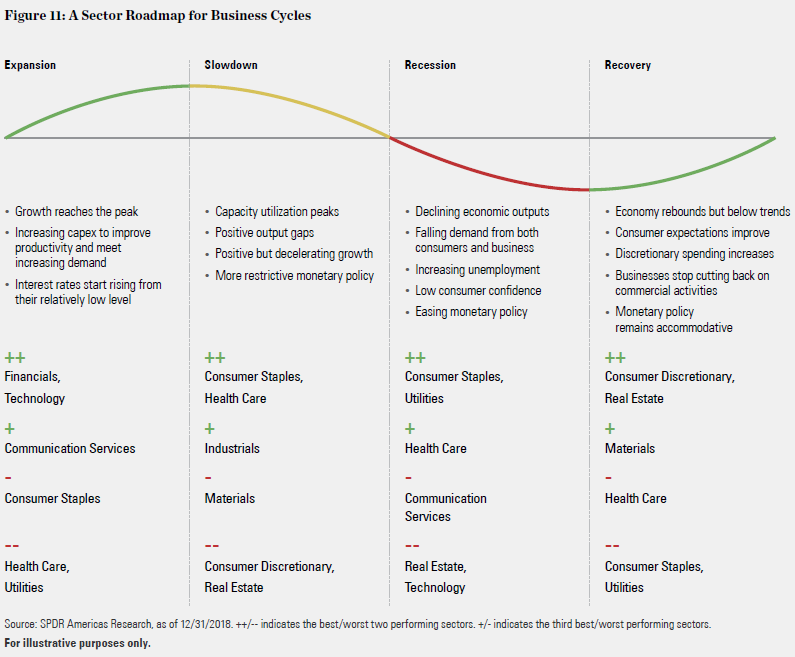

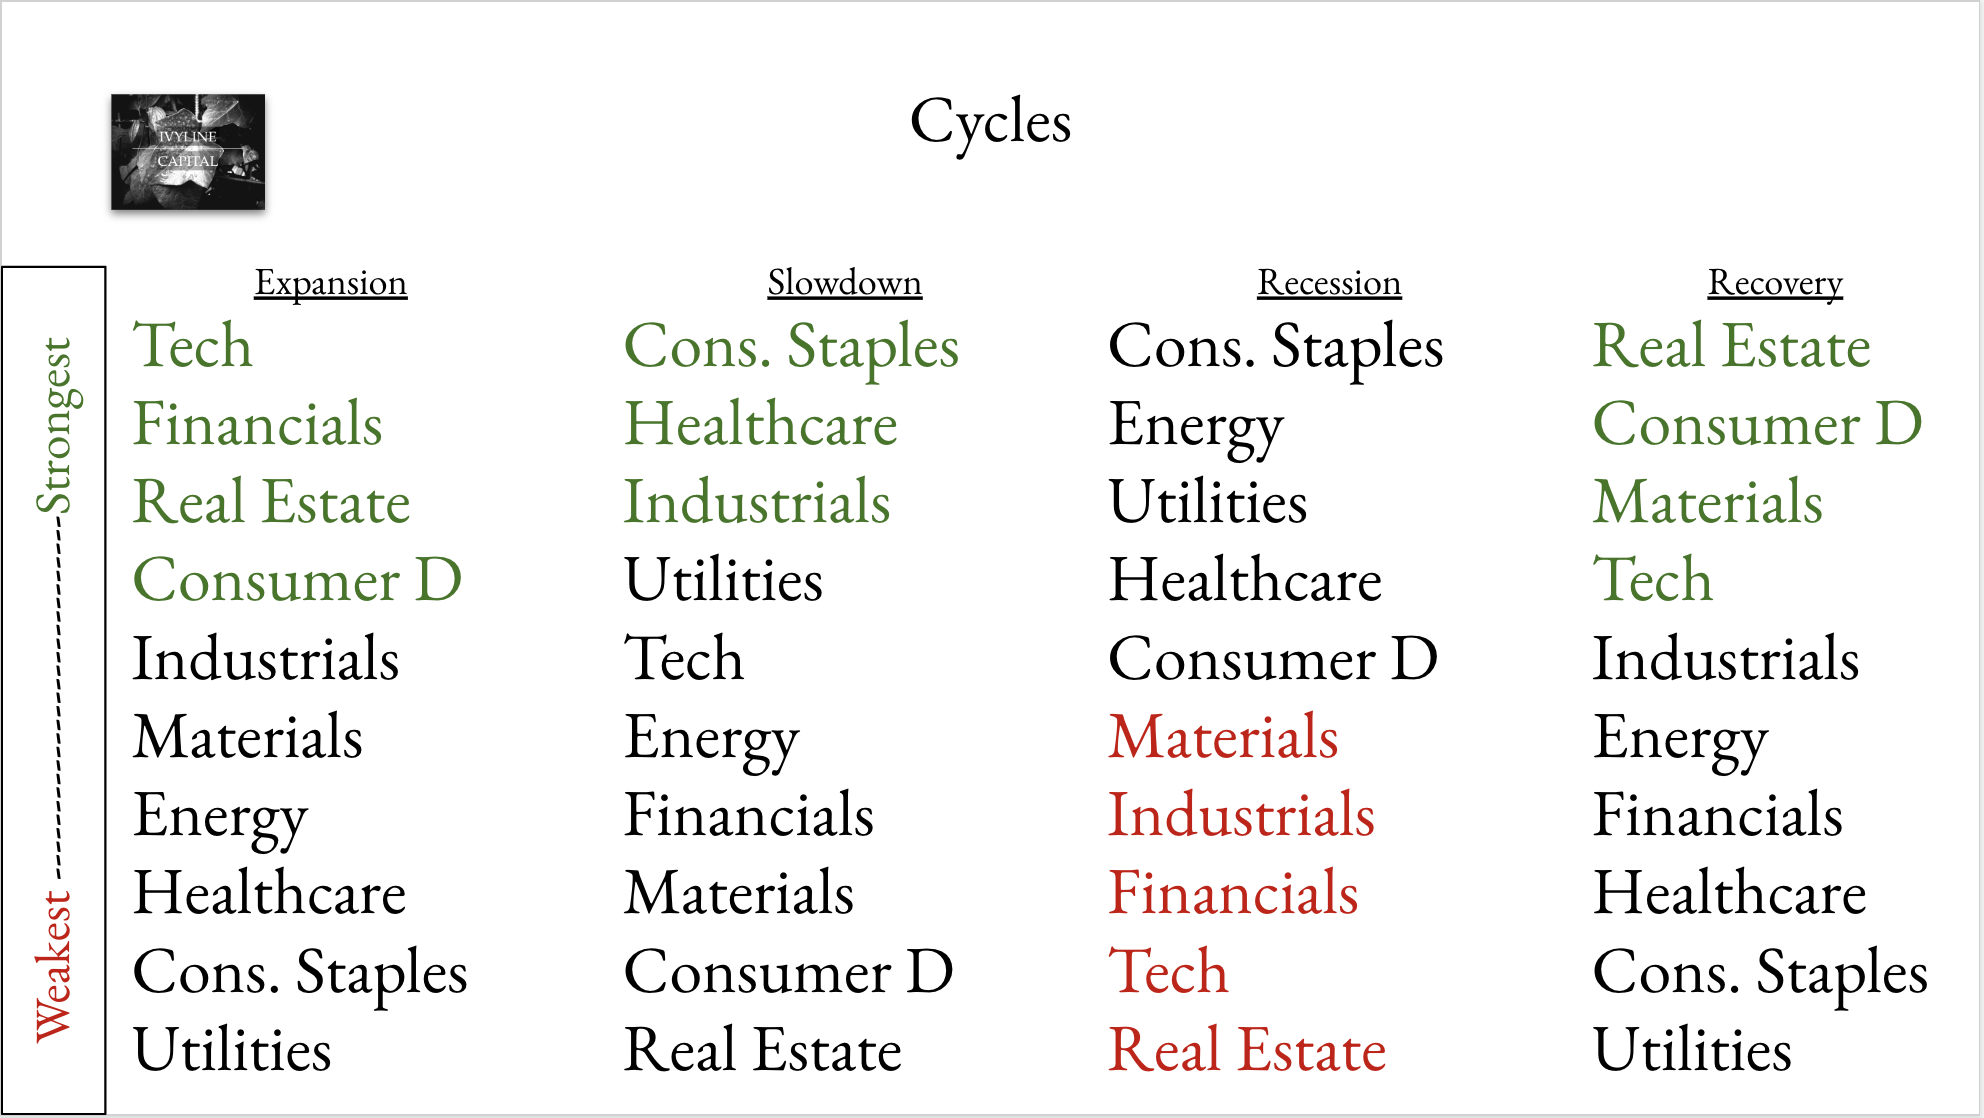

In [95]:
cycles_ = ['Expansion','Slowdown','Recession','Recovery']

path=r"..\data\\interim\\Business cycles.png"
display(Image.open(path))
path=r"..\data\\interim\\Business Cycles-2.png"
display(Image.open(path))

In [96]:
sector_performance_returned_no_dup = sector_performance_return.loc[~sector_performance_return.index.duplicated(keep ='first')]
sector_performance_return_pvt = sector_performance_returned_no_dup[sector_performance_returned_no_dup.iloc[-1].sort_values(ascending=False).index]

sector_performance_return_pvt_heatmap = sector_performance_return_pvt.style.background_gradient(cmap = cm,axis=None)
display(sector_performance_return_pvt_heatmap)

sector_performances = pd.DataFrame()
sector_performances_values = pd.DataFrame()
for c in sector_performance_returned_no_dup.T.columns:
    #print(c)
    temp = pd.DataFrame(sector_performance_returned_no_dup.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(sector_performance_returned_no_dup.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    sector_performances_values = pd.concat([sector_performances_values,temp2],axis=1)
    
A = sector_performances_values
B = sector_performance_returned_no_dup.T

df = B.style.apply(b_g,cmap='RdYlGn')

display(df)


,Consumer Discretionary ETF,Information Technology ETF,Consumer Staples ETF,SP500,SP1500,SP400,Health Care ETF,Communication Services ETF,Utilities ETF,Real Estate ETF,SP600,Industrials ETF,Financials ETF,Materials ETF,Energy ETF
2017-03-31 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2017-06-30 00:00:00,0.028386,0.041388,0.010040,0.030708,0.030375,0.031752,0.072895,-0.024136,0.022113,0.017375,0.018327,0.042167,0.038955,0.026999,-0.078709
2017-09-30 00:00:00,0.014521,0.083223,-0.012346,0.045666,0.044807,0.035020,0.040565,0.015498,0.031518,0.008095,0.064962,0.052781,0.052789,0.066617,0.069612
2017-12-31 00:00:00,0.097848,0.093087,0.059268,0.069917,0.066880,0.074139,0.018576,0.000763,0.000687,0.012742,0.038747,0.066175,0.073683,0.071798,0.073946
2018-03-31 00:00:00,-0.001942,0.020711,-0.073521,-0.024130,-0.021321,-0.003978,-0.020049,-0.085669,-0.033734,-0.086159,-0.011631,-0.033542,-0.015065,-0.072483,-0.078807
2018-06-30 00:00:00,0.088528,0.080437,0.006353,0.047568,0.052094,0.045520,0.055259,0.035862,0.053422,0.094633,0.106722,-0.008057,-0.011331,0.036210,0.150528
2018-09-30 00:00:00,0.066008,0.117719,0.050064,0.078236,0.070536,0.032902,0.137698,0.023115,0.019751,0.000044,0.032842,0.094874,0.031675,0.007338,0.021911
2018-12-31 00:00:00,-0.162070,-0.174415,-0.055862,-0.137319,-0.142834,-0.172165,-0.108129,-0.143117,0.009925,-0.058855,-0.193040,-0.183620,-0.138848,-0.154310,-0.267451
2019-03-31 00:00:00,0.157197,0.217473,0.111156,0.144236,0.151853,0.157497,0.081835,0.139541,0.103055,0.173365,0.124660,0.183161,0.109942,0.126958,0.178564
2019-06-30 00:00:00,0.040127,0.054745,0.036556,0.040369,0.039106,0.030815,0.017469,0.035928,0.035855,0.015389,0.010843,0.034436,0.067026,0.040951,-0.048754


,2017-03-31 00:00:00,2017-06-30 00:00:00,2017-09-30 00:00:00,2017-12-31 00:00:00,2018-03-31 00:00:00,2018-06-30 00:00:00,2018-09-30 00:00:00,2018-12-31 00:00:00,2019-03-31 00:00:00,2019-06-30 00:00:00,2019-09-30 00:00:00,2019-12-31 00:00:00,2020-03-31 00:00:00,2020-06-30 00:00:00,2020-09-30 00:00:00,2020-12-31 00:00:00,2021-03-31 00:00:00,2021-06-30 00:00:00,2021-09-30 00:00:00,2021-12-31 00:00:00,2022-03-31 00:00:00,2022-06-30 00:00:00,2022-07-14 00:00:00
SP1500,nan,0.030375,0.044807,0.066880,-0.021321,0.052094,0.070536,-0.142834,0.151853,0.039106,0.006291,0.090490,-0.205302,0.206715,0.086119,0.132216,0.070761,0.080495,0.000378,0.103038,-0.049102,-0.163728,0.001291
SP500,nan,0.030708,0.045666,0.069917,-0.024130,0.047568,0.078236,-0.137319,0.144236,0.040369,0.011423,0.089876,-0.194477,0.201618,0.090383,0.121185,0.063518,0.083593,0.002523,0.106772,-0.049099,-0.164711,0.001750
SP600,nan,0.018327,0.064962,0.038747,-0.011631,0.106722,0.032842,-0.193040,0.124660,0.010843,-0.004200,0.082573,-0.328050,0.223617,0.032878,0.312278,0.184526,0.043034,-0.030694,0.049293,-0.058344,-0.144536,-0.011738
SP400,nan,0.031752,0.035020,0.074139,-0.003978,0.045520,0.032902,-0.172165,0.157497,0.030815,-0.009122,0.066590,-0.247693,0.259149,0.068091,0.211458,0.084662,0.033635,-0.024123,0.077726,-0.089783,-0.178547,0.000164
Communication Services ETF,nan,-0.024136,0.015498,0.000763,-0.085669,0.035862,0.023115,-0.143117,0.139541,0.035928,-0.002023,0.086727,-0.187109,0.224230,0.097573,0.182130,0.083288,0.108092,-0.021207,-0.037011,-0.114414,-0.216743,-0.004041
Consumer Discretionary ETF,nan,0.028386,0.014521,0.097848,-0.001942,0.088528,0.066008,-0.162070,0.157197,0.040127,0.002509,0.056223,-0.231167,0.379795,0.192380,0.172875,0.073815,0.064435,-0.012866,0.099010,-0.103975,-0.254816,0.034643
Consumer Staples ETF,nan,0.010040,-0.012346,0.059268,-0.073521,0.006353,0.050064,-0.055862,0.111156,0.036556,0.056319,0.036517,-0.141472,0.094561,0.098022,0.074374,0.030385,0.029888,-0.018026,0.115277,-0.019862,-0.053953,0.006852
Energy ETF,nan,-0.078709,0.069612,0.073946,-0.078807,0.150528,0.021911,-0.267451,0.178564,-0.048754,-0.075658,0.054552,-0.523877,0.332245,-0.188315,0.300830,0.324479,0.126094,-0.026222,0.050203,0.379204,-0.070721,-0.057304
Financials ETF,nan,0.038955,0.052789,0.073683,-0.015065,-0.011331,0.031675,-0.138848,0.109942,0.067026,0.013235,0.096390,-0.330709,0.135641,0.028859,0.253698,0.165207,0.074954,0.024323,0.042310,-0.032929,-0.173466,-0.023837
Health Care ETF,nan,0.072895,0.040565,0.018576,-0.020049,0.055259,0.137698,-0.108129,0.081835,0.017469,-0.035439,0.147851,-0.131539,0.164463,0.062281,0.101111,0.025327,0.083442,0.000121,0.077925,-0.045192,-0.074220,-0.002463


In [97]:
"""
#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

#seasonal_indexes[si]
seasonally_adjusted = pd.DataFrame()

for s in sector_performance_return.columns:
    
    s_ = pd.DataFrame(sector_performance_return[s])
    #print(sector_performance_return[s])
    years = []
    quarters = []
    
    for d in s_.index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)
        
    s_['Quarter'] = quarters
    si_ = seasonal_indexes.loc[s]
    
    modified = pd.DataFrame()
    #print(si_.index)
    for s_i_ in si_.index:
        #print(s_i_)
        #when it finds the last date (which hopefully isn't a quarter date)
        if(np.sum(np.array(si)==s_i_)==0):
            #print("don't modify")
            #print(s_i_)
            match = []
            for entry in si:
                if(int(s_i_.rsplit("-")[0])<=int(entry.rsplit("-")[0])):
                    match = entry
                    break            

            delta_months = int(match.rsplit("-")[0])-int(s_i_.rsplit("-")[0])
            delta_days_ = int(match.rsplit("-")[1])-int(s_i_.rsplit("-")[1])
            
            delta_days = int(delta_months*(91.25/3)+delta_days_)
            #daily interest
            
            #print(delta_days)
            #print(seasonal_indexes.loc[s].loc[match])
            seasonal_index_to_daily = (1+seasonal_indexes.loc[s].loc[match])**(1/91.25)-1
            #print("Seasonal Index to Daily Discounted Interest Rate:",seasonal_index_to_daily)
            daily_extrapolated = (1+seasonal_index_to_daily)**delta_days-1
            #print(daily_extrapolated)
            #print("Daily ^ delta_days:",daily_extrapolated)
            
            #print(match)
            #print(s_i_)
            seasonally_adjusted_column = pd.DataFrame([seasonal_indexes.loc[s].loc[match] - daily_extrapolated],columns=[s],index=[s_.index[-1]])
            
            
        else:
            seasonally_adjusted_column = pd.DataFrame(s_[s][s_['Quarter']==s_i_] - seasonal_indexes.loc[s].loc[s_i_],columns=[s])
        modified = pd.concat([modified,seasonally_adjusted_column],axis=0)
        modified.sort_index(inplace=True)
    #print(modified)
    seasonally_adjusted = pd.concat([seasonally_adjusted,modified],axis=1)

print("Comparative to Seasonal Indexes, tells you who is over or underperforming.")
print("This is Seasonal Index - Extrapolated Current Quarter.")
print("+: seasonal > current")
print("-: current > seasonal")

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
    
    
std_indexes_seas_adj = pd.DataFrame()
seasonal_indexes_seas_adj = pd.DataFrame()

temp_ = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1])
temp_.columns = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1]).columns.strftime('%Y-%m-%d')
display(temp_.sort_values(by=temp_.columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))

#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))

for spr in seasonally_adjusted.columns:
    #print(spr)
    s = seasonally_adjusted[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in seasonally_adjusted[spr].index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    #print(ct)
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes_seas_adj = pd.concat([std_indexes_seas_adj,ct_std],axis=1)
    seasonal_indexes_seas_adj = pd.concat([seasonal_indexes_seas_adj,ct],axis=1)

seasonal_indexes_seas_adj.columns = seasonally_adjusted.columns

std_indexes_seas_adj.columns = seasonally_adjusted.columns
    
seasonal_indexes_seas_adj = seasonal_indexes_seas_adj.T

std_indexes_seas_adj = std_indexes_seas_adj.T

sector_performances_sea_adj = pd.DataFrame()
sector_performances_values_sea_adj = pd.DataFrame()
for c in seasonally_adjusted.T.columns:
    temp = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False).index,columns=[c])
    temp2 = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False),columns=[c])
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances_sea_adj = pd.concat([sector_performances_sea_adj,temp],axis=1)
    sector_performances_values_sea_adj = pd.concat([sector_performances_values_sea_adj,temp2],axis=1)

A = sector_performances_values_sea_adj
B = sector_performances_sea_adj

df_sea_adj = B.style.apply(b_g,cmap='RdYlGn')
display(df_sea_adj)
"""

'\n#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)\n#pd.crosstab(shares_viz[\'Year\'], shares_viz[\'Month\'])\n\n#seasonal_indexes[si]\nseasonally_adjusted = pd.DataFrame()\n\nfor s in sector_performance_return.columns:\n    \n    s_ = pd.DataFrame(sector_performance_return[s])\n    #print(sector_performance_return[s])\n    years = []\n    quarters = []\n    \n    for d in s_.index:\n        d_ = d.strftime(\'%Y-%m-%d\')\n        #print(d_)\n\n        datem = dt.datetime.strptime(d_, "%Y-%m-%d")\n        years.append(str(datem.year))\n        #print(datem.year)       # 2021\n        m = datem.month\n        d = datem.day\n        if(len(str(m))==1):\n            m = \'0\'+str(m)\n        else:\n            m = str(m)\n        if(len(str(d))==1):\n            d = \'0\'+str(d)\n        else:\n            d = str(d)\n        quarters.append(m+"-"+d)\n        \n    s_[\'Quarter\'] = quarters\n    si_ = seasonal_indexes.loc[s]\n    \n    modified = pd.DataFrame()\n    #print

In [98]:
"""
index_performance = []
for v in indexes['Symbol'].values:
    index_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_i = pd.DataFrame(index_performance,index=indexes.index)
temp_i.columns = ['Symbol','risk_trend_factor']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']
index_risk_sorted
"""

"\nindex_performance = []\nfor v in indexes['Symbol'].values:\n    index_performance.append([v,screener.loc[v]['risk_trend_factor']])\ntemp_i = pd.DataFrame(index_performance,index=indexes.index)\ntemp_i.columns = ['Symbol','risk_trend_factor']\nindex_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()\nindex_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']\nindex_risk_sorted\n"

In [99]:
"""
sector_performance = []
for v in sectors['Symbol'].values:
    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_v = sectors.reset_index()
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    
sectors_risk_sorted
"""

"\nsector_performance = []\nfor v in sectors['Symbol'].values:\n    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])\ntemp_v = sectors.reset_index()\ntemp_v.columns = ['Sector','Symbol']\nsectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    \nsectors_risk_sorted\n"

Rolling Quarterly Mean Return


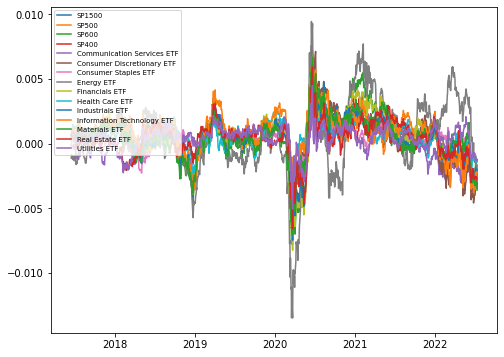

In [100]:
print("Rolling Quarterly Mean Return")
plt.plot(sector_performance_Q_smoothed_return)
plt.legend([*[i for i in indexes.index],*[v for v in sectors.index]],loc=2,fontsize=7)
plt.show()

Quarterly Returns


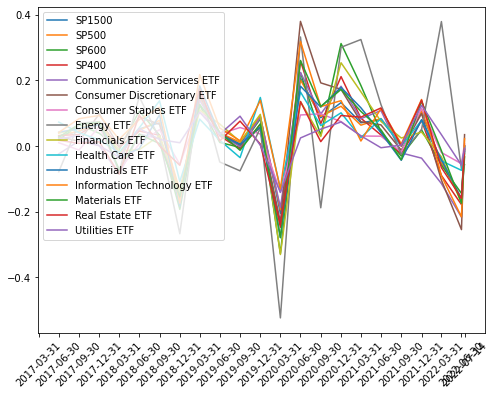

In [101]:
print ("Quarterly Returns")
for v in sector_performance_return.T.index:
    subset = pd.DataFrame(sector_performance_return.T.loc[v])
    subset.columns = ['Return']
    plt.plot(subset)
    plt.xticks(subset.index, rotation=45)
plt.legend(sector_performance_return.T.index,loc=2)    
plt.show()


In [102]:
"""
plt.plot(seasonal_indexes[si].T)
plt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)
plt.show()
"""

'\nplt.plot(seasonal_indexes[si].T)\nplt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)\nplt.show()\n'

In [103]:
#threshold = 0

In [104]:
#risk_trend_threshold

In [105]:
#market_data['sector'] = stock_fundamentals['sector']

In [106]:
#screener[['risk_trend_factor']].replace(['missing','error'], np.NaN).dropna().hist()

In [107]:
#len(screener)

In [108]:
#prices_df.columns

In [109]:
#threshold

In [110]:
#threshold_value = summary.dropna()['risk_trend_factor'].quantile([threshold])

In [111]:
fred_pvt_sample = completed_fred_pvt_df[fred_names].asfreq('D').interpolate(method='time').asfreq('Q').dropna()

In [112]:
temp_filter = screener_sorted['risk_trend_factor'].replace(['missing','error'], np.nan).dropna()

In [113]:
filtered_screener_sorted = screener_sorted.loc[temp_filter[temp_filter>0].index]

In [114]:
filtered_screener_sorted

,Date,MIN_Lookback_One_Year,MIN_Lookback_2_Months,MIN_Lookback_1_Months,risk_trend_factor,risk_per_share,volume_factor,Adj Close,21dBOLD,21dMA-TP,21dBOLU,90dSMA,90dSDev,adf,hurst,sector_risk_trend_factor,Sector,Sector Symbol,Market Index,Index Symbol
ACC,2022-07-14 00:00:00,50.950001,65.019997,65.220001,9.702893,1.380001,1.553868,64.860001,64.06536,64.592024,65.118689,64.457778,1.243834,0.978154,0.431053,error,error,error,SP400,MDYG
MTOR,2022-07-14 00:00:00,32.93,36.279999,36.299999,5.898316,0.59,1.503829,36.330002,35.952245,36.1975,36.442755,36.084286,0.141247,0.363557,0.438613,-8.0569,Consumer Cyclical,VCR,SP600,SLY
PSB,2022-07-14 00:00:00,165.850006,189.830002,189.830002,5.567396,2.819992,2.27646,187.070007,185.789351,186.793849,187.798347,185.077937,5.821603,0.83398,0.481761,error,error,error,SP400,MDYG
Y,2022-07-14 00:00:00,737.890015,862.869995,862.869995,4.249453,9.099976,1.522722,834.099976,829.832911,832.626623,835.420336,833.966704,2.815486,0.470967,0.465034,-5.69213,Financial Services,VFH,SP400,MDYG
GCP,2022-07-14 00:00:00,27.780001,32.279999,32.279999,2.663548,1.070002,1.940731,31.73,30.783464,31.344941,31.906417,31.187063,0.26715,0.16194,0.457724,error,error,error,SP600,SLY
HRB,2022-07-14 00:00:00,26.23,33.380001,36.830002,2.606401,5.310001,0.735396,36.759998,32.559212,35.287222,38.015233,32.386151,4.041069,0.923685,0.450664,-8.0569,Consumer Cyclical,VCR,SP400,MDYG
MUSA,2022-07-14 00:00:00,159.0,259.859985,262.579987,2.412427,52.469986,1.421215,269.339996,211.609649,240.039085,268.468521,241.380594,10.453156,0.998518,0.41361,-8.0569,Consumer Cyclical,VCR,SP400,MDYG
MCK,2022-07-14 00:00:00,204.660004,339.940002,339.940002,2.364973,40.139984,1.167083,326.48999,300.673333,318.957778,337.242224,320.911729,8.568901,0.998779,0.460772,-3.019525,Healthcare,VHT,SP500,SPY
ROG,2022-07-14 00:00:00,206.130005,274.51001,274.51001,2.287221,15.179993,1.027464,263.290009,256.366372,260.071944,263.777516,264.308135,6.011478,0.734077,0.479483,-6.166308,Technology,VGT,SP600,SLY
FCN,2022-07-14 00:00:00,147.380005,170.309998,172.690002,2.273819,30.859985,0.989758,186.850006,159.387693,177.037341,194.68699,168.666151,8.795246,0.975154,0.400081,-5.554051,Industrials,VIS,SP400,MDYG


In [115]:

with localconverter(ro.default_converter + pandas2ri.converter):
      r_from_pd_df = ro.conversion.py2rpy(fred_pvt_sample.melt(ignore_index=False).reset_index().rename(columns={'index': 'Date'}))


In [116]:
#ro.X11()
#ro.windows()
ro.r('''

my_mean <- function(x, na.rm=TRUE) {
  mean(x, na.rm = na.rm)
}

f <- function(y) {
#print(y)

#library(arfima)
#varvefd = arfima(y)
#d = summary(varvefd)$coef[[1]][1]
#return(d)

tsfeature_tbl <- y %>%
group_by(variable) %>%
tk_tsfeatures(
  .date_var = Date,
  .value    = value,
  .period   = 4,
  .features = c("frequency", "stl_features", "entropy", "acf_features", "my_mean"),
  .scale    = TRUE,
  .prefix   = "ts_"
) %>%
ungroup()
    
print(tsfeature_tbl)

set.seed(123)

cluster_tbl <- tibble(
    cluster = tsfeature_tbl %>% 
        select(-variable) %>%
        as.matrix() %>%
        kmeans(centers = 7, nstart = 100) %>%
        pluck("cluster")
) %>%
    bind_cols(
        tsfeature_tbl
    )

cluster_tbl

cluster_tbl %>%
    select(cluster, variable) %>%
    right_join(y, by = "variable") %>%
    group_by(variable) %>%
    plot_time_series(
      Date, value, 
      .color_var   = cluster, 
      .facet_ncol  = 2, 
      .interactive = FALSE
    )
plot(cluster_tbl)

return(tsfeature_tbl)
}
''')
grdevices.png(file="..\\reports\\figures\\temp.png", width=4096, height=1024)
r_f = ro.globalenv['f']
d=(r_f(r_from_pd_df))
#rprint(pp)

time.sleep(3)
#grdevices.dev_copy(device = r.png, filename = "plot.png", width = 1000, height = 500)
grdevices.dev_off()

#From here optional, if you want a waiting time
#Elsewise close the plot manually afterwards with grdevices.dev_off()

#grdevices.dev_off()
#grdevices.dev_off()


# A tibble: 21 x 22
   variable    ts_frequency ts_nperiods ts_seasonal_period ts_trend    ts_spike
   <chr>              <dbl>       <dbl>              <dbl>    <dbl>       <dbl>
 1 CONSUMER               4           1                  4    0.991 0.000000770
 2 WPUSI019011            4           1                  4    0.971 0.00000614 
 3 WPU101                 4           1                  4    0.986 0.00000100 
 4 GVZCLS                 4           1                  4    0.710 0.000757   
 5 UNRATE                 4           1                  4    0.710 0.00107    
 6 VIXCLS                 4           1                  4    0.536 0.00158    
 7 BUSLOANS               4           1                  4    0.919 0.0000474  
 8 AWHAETP                4           1                  4    0.918 0.0000646  
 9 UMCSENT                4           1                  4    0.894 0.0000849  
10 TDSP                   4           1                  4    0.757 0.000503   
# ... with 11 more r

array([1], dtype=int32)

In [117]:
pca = PCA(n_components=0.99, svd_solver='full')

X = np.array(d.iloc[:,1:])

pca.fit(scale(X))
#pca.explained_variance_
pca.explained_variance_ratio_.cumsum()
X_pca = pd.DataFrame(pca.transform(d.iloc[0:,1:]))
X_pca.index = d.index
X_pca.sort_values(by=[0],ascending=False,inplace=True)

TSS_ = []
BSS_ = []
WSS_ = []
silhouettes_ = []

for k in range(2,int(len(d)/2)):
    model = KMeans(n_clusters=k, random_state=0, n_init=100).fit(X)
    #print(model.inertia_)

    codebook = np.array(model.cluster_centers_)
    partition, euc_distance_to_centroids = vq(X, codebook)
    WSS = np.sum(euc_distance_to_centroids**2)
    
    silhouette_avg = silhouette_score(X, model.labels_)

    silhouettes_.append(silhouette_avg)
    
    TSS = np.sum((X-X.mean(0))**2)

    BSS = TSS - WSS

    TSS_.append(TSS)
    BSS_.append(BSS)
    WSS_.append(WSS)
    
    #print(TSS, WSS, BSS)


In [118]:

init_min = 2
init_max = 5


mink = 2
maxk = 6

tss, bss, wss = findOptimalK_ANOVA(X_pca, mink = mink, maxk = maxk)

2
3
wss 132.481509398946
tot_ss 197.8430095399954
bss 65.36150014104938
3
4
wss 102.75923202472659
tot_ss 197.8430095399954
bss 95.08377751526875
4
5
wss 64.60011926444766
tot_ss 197.8430095399954
bss 133.24289027554772
5
6


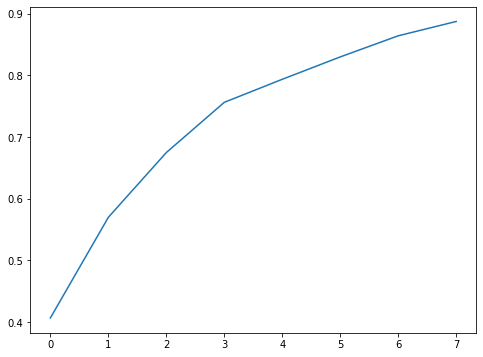

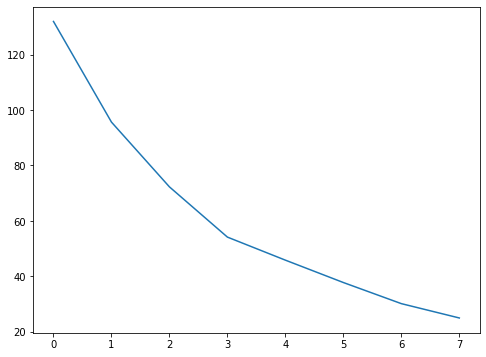

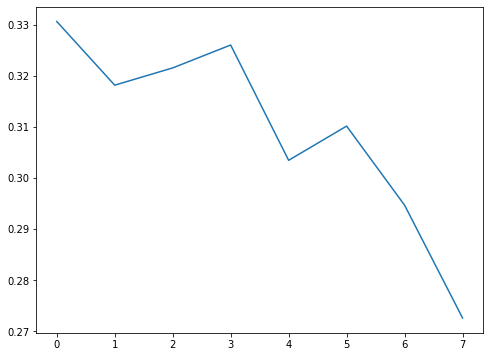

In [119]:
plt.plot(np.array(BSS_)/np.array(TSS_))
plt.show()
plt.plot(np.array(WSS_))
plt.show()
plt.plot(np.array(silhouettes_))
plt.show()



3


C:\Users\User\AppData\Local\Temp\ipykernel_4004\1748299227.py:7: RuntimeWarning: invalid value encountered in true_divide
  temp_df = pd.DataFrame(bss_/wss_).replace([np.inf, -np.inf, np.NaN], 0)


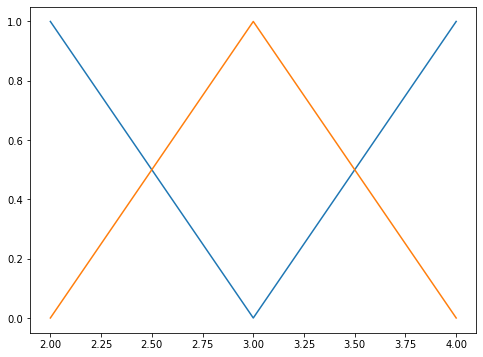

In [120]:

bss_ = findknee(bss)
bss_ = bss_/np.max(bss_)

wss_ = findknee(np.array(pd.DataFrame(wss).mean(1)))
wss_ = wss_/np.max(wss_)

temp_df = pd.DataFrame(bss_/wss_).replace([np.inf, -np.inf, np.NaN], 0)
temp_df.index = np.array(range(0,len(wss_)))+mink
#plt.plot(temp_df)

set_ = np.abs(temp_df-1)
plt.plot(set_)

optimal_k = np.argmin(set_)+mink
plt.plot(abs(set_-1))
 
print(optimal_k)


In [121]:
clf = KMeansConstrained(n_clusters=optimal_k, size_min=init_min, size_max=max(np.ceil(len(X_pca)/optimal_k),init_max), init='k-means++', n_init=100, max_iter=100, tol=0.0001, verbose=False, random_state=None, copy_x=True, n_jobs=4)
clf.fit_predict(X_pca)

labels = clf.labels_
clusters = clf.n_clusters
centers = clf.cluster_centers_

print(labels)

tot_ss, BSS, within_ss = deriveANOVA(clf, X_pca)

Global_F = (BSS/(optimal_k-1))/(np.mean(within_ss)/(len(X_pca)-optimal_k))
global_sig = 1-f.cdf(Global_F, (len(X_pca)-optimal_k), len(X_pca)-1)

ind_F_scores = []

for w in range(0,len(within_ss)):

    dfn = (optimal_k-1)
    dfd = np.sum(labels==w)-optimal_k

    F_score = (BSS/dfn)/(within_ss[w]/(dfd))
    ind_F_scores.append(F_score)

print("Global F:",Global_F)
print("Global Sig:",global_sig)
print("F-Scores:", ind_F_scores)

print("P-Scores:", 1-f.cdf(ind_F_scores, dfn, dfd))

X_pca['cluster'] = labels

[2 2 0 2 0 2 0 0 0 0 2 2 1 2 0 1 1 1 1 1 1]
wss 102.75923202472659
tot_ss 197.8430095399954
bss 95.08377751526875
Global F: 24.983273447338586
Global Sig: 6.254103901426333e-10
F-Scores: [3.5930530894154304, 7.128404922900171, 8.21268512714546]
P-Scores: [0.12786807 0.0480032  0.0383513 ]


K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.02700638771057129 seconds.
K=3 fitted in 0.027994871139526367 seconds.
K=4 fitted in 0.02599811553955078 seconds.
K=5 fitted in 0.029730796813964844 seconds.
K=6 fitted in 0.030998706817626953 seconds.
K=7 fitted in 0.03800821304321289 seconds.


Clustergram(k_range=range(1, 8), backend='sklearn', method='kmeans', kwargs={})

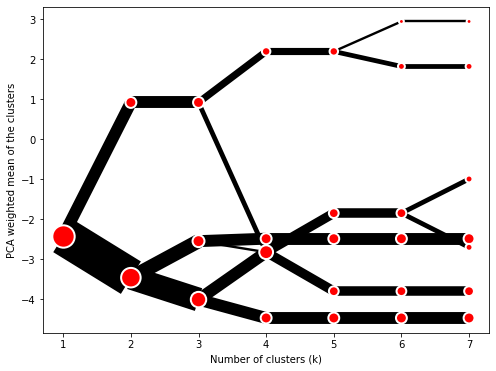

In [122]:


cgram = Clustergram(range(1, 8))
cgram.fit(X_pca)
cgram.plot()
cgram

In [123]:

lengths = []
for i in range(0,max(X_pca['cluster'])+1):
    subset = d.loc[X_pca[X_pca['cluster']==i].index]
    lengths.append(len(subset))
    
colors = ['purple','cyan','magenta','green','red','black','pink','yellow','blue','brown','orange','grey']
my_cmap = LinearSegmentedColormap.from_list(
    'color_map', colors, N=max(lengths))

rescale = lambda y: (y - 0) / (np.max(lengths) - 0)    


Group:  0


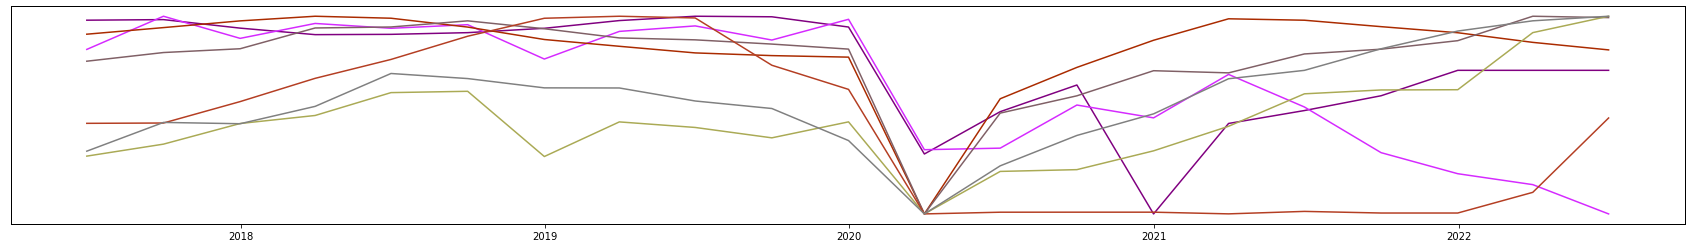

Group:  1


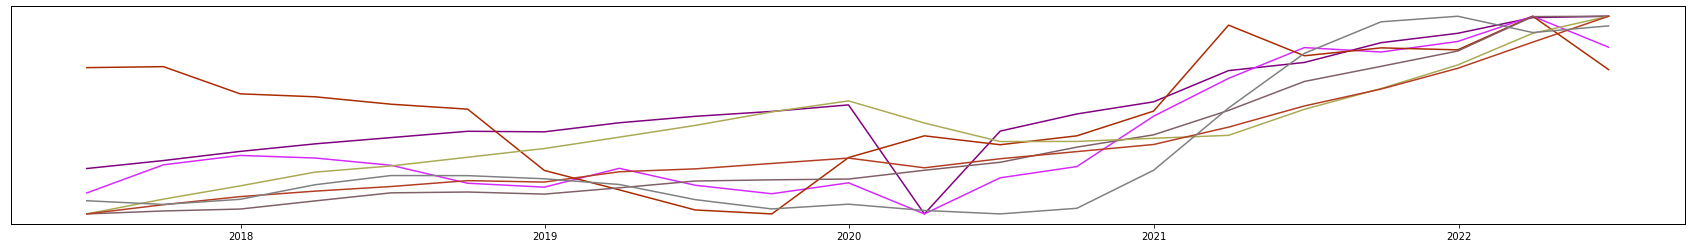

Group:  2


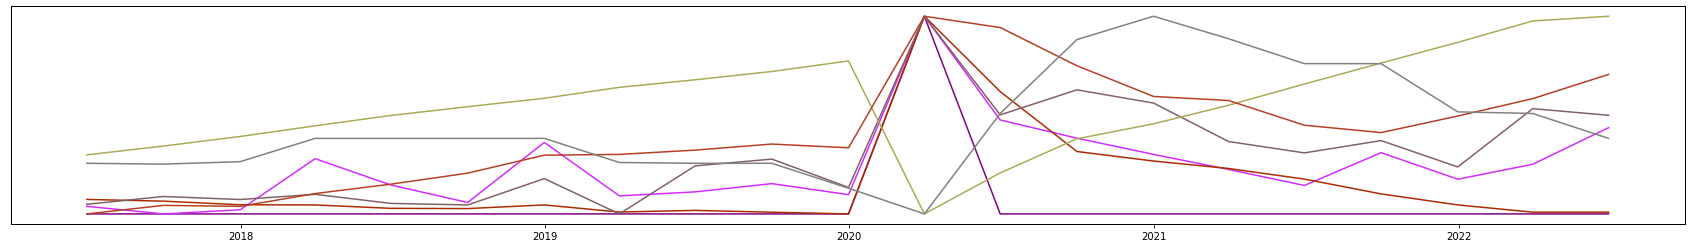

In [124]:

for i in range(0,max(X_pca['cluster'])+1):
    print("Group: ",i)
    subset = d.loc[X_pca[X_pca['cluster']==i].index]
    #
    for c_ in range(0,len(subset['variable'])):
        c = subset['variable'].values[c_]
        try:
            #print(dict_fred[c])
            display(html_print(' '.join([cstr(ti, color=ci) for ti,ci in ((dict_fred[c], colors[c_]),)])))

            #display(html_print(' '.join([cstr(ti, color=my_cmap(rescale(c_))) for ti in (('hello my name is'),)])))
            #print(colored("hello red world", my_cmap(rescale(c_))))
            if(c_==0):
                fig, ax1 = plt.subplots( figsize=(30,4))
                ax1.plot(fred_pvt_sample[c],color=my_cmap(rescale(c_)))
                ax1.get_yaxis().set_ticks([])
            else: 
                ax2 = ax1.twinx()
                ax2.plot(fred_pvt_sample[c],color=my_cmap(rescale(c_)))
                ax2.get_yaxis().set_ticks([])
        #ax1.legend(subset['variable'].values,loc=2)
        except:
            pass
    plt.show()

In [125]:
filter_ = fred_pvt_sample.columns.tolist()
def f3(Y):
    
    #Y = x
    #output_slider_variable.value
    internalFilter = filter_.copy()
    internalFilter.remove(Y)
    all_data_ = pd.concat([fred_pvt_sample[Y],fred_pvt_sample[internalFilter]], axis=1)    
    #print(all_data_.describe())
    display(fred_pvt_sample.describe())
    #x_ticks = all_data_.index[np.arange(0, len(all_data.index), int(len(internalFilter)/5))]
    x_ticks  = []
    for index, element in enumerate(fred_pvt_sample.index):
        if index % int(np.round(len(fred_pvt_sample.index)/10)) == 0:
            x_ticks.append(element)
    plt.plot(fred_pvt_sample[Y])
    plt.xticks(x_ticks, rotation = 45)
    plt.show()        
    plt.hist(fred_pvt_sample[Y], bins='auto')
    plt.show()
    diff = pd.DataFrame((fred_pvt_sample[Y].pct_change())).dropna()
    plt.hist(diff, bins='auto')
    plt.show()
    return(fred_pvt_sample)
    
out = interactive(f3, Y=filter_)

#output_slider_variable.observe(f4, 'value')

print("choose Y")
display(out)


choose Y


interactive(children=(Dropdown(description='Y', options=('CONSUMER', 'WPUSI019011', 'WPU101', 'GVZCLS', 'UNRAT…

nominal, pct_change, pct_change().cumsum
Consumer Loans CONSUMER


C:\Users\User\AppData\Local\Temp\ipykernel_4004\1907383185.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_4004\1907383185.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_4004\1907383185.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index

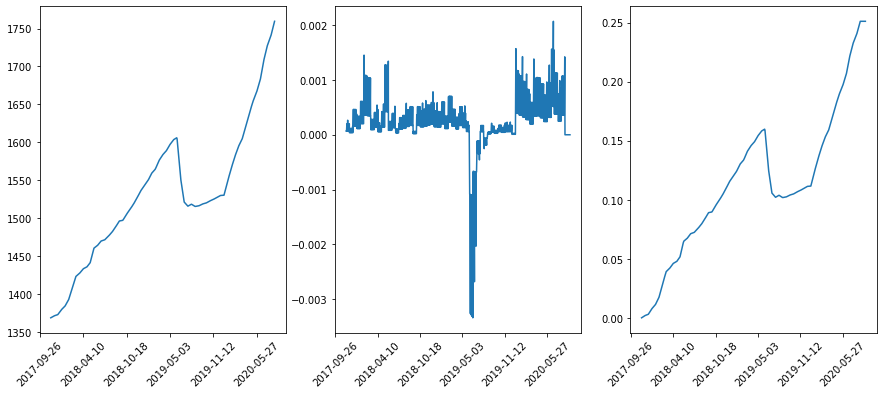

Copper WPUSI019011


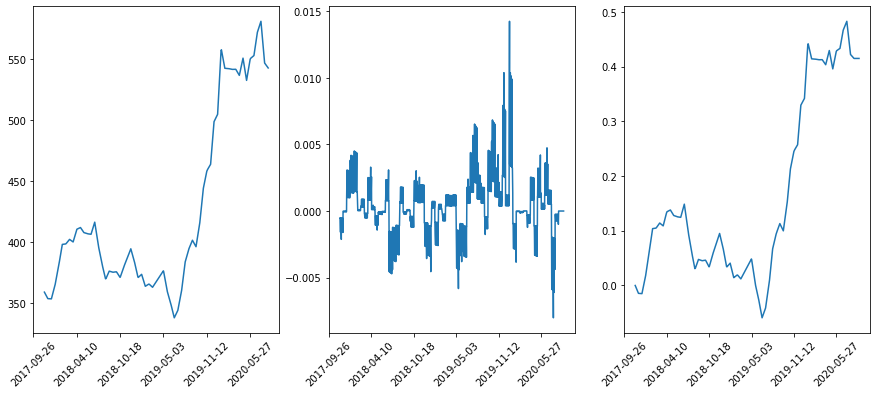

Iron and Steel WPU101


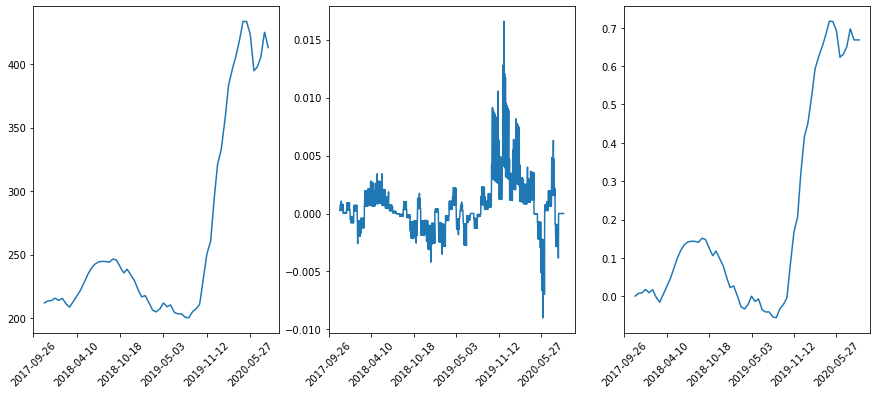

Gold GVZCLS


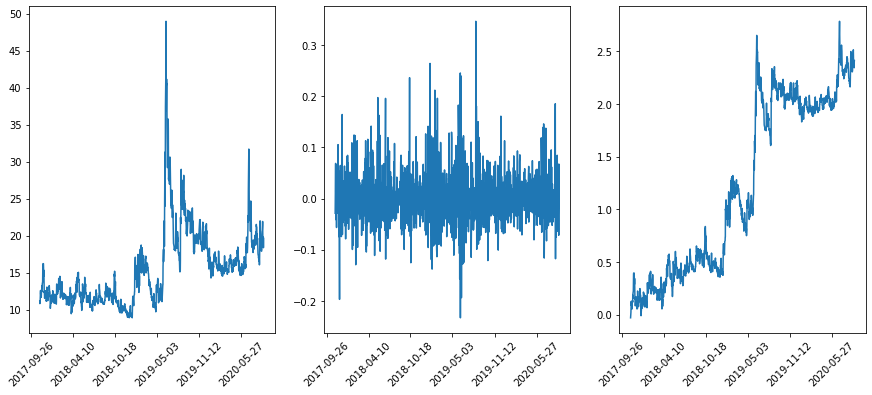

Unemployment UNRATE


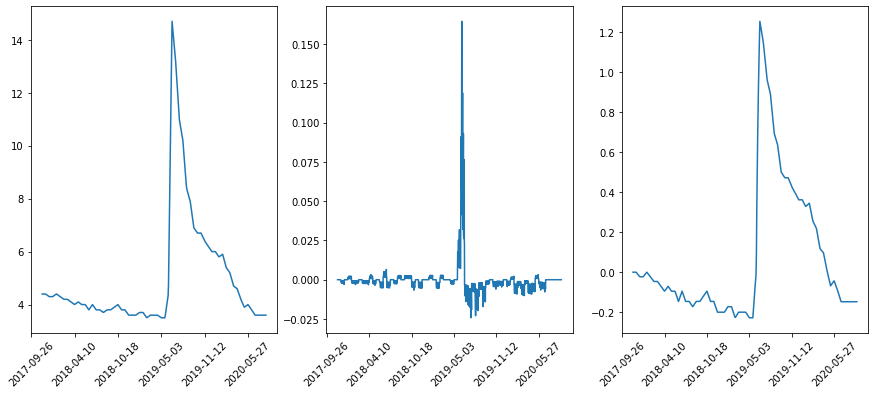

Market volatility VIXCLS


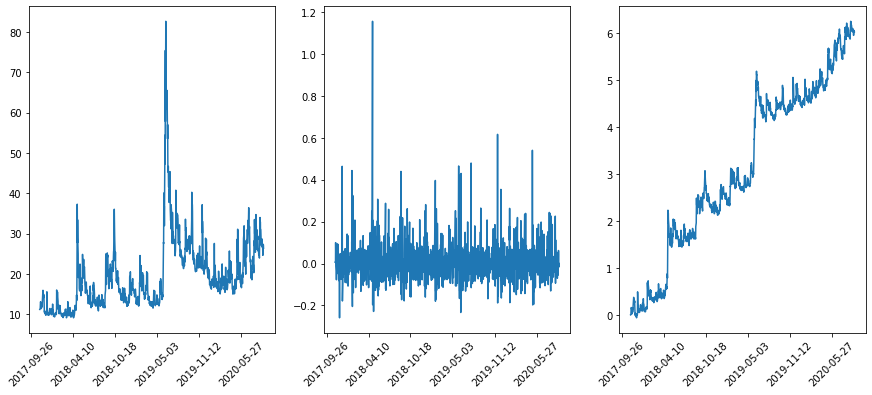

Commercial-Industrial Loans BUSLOANS


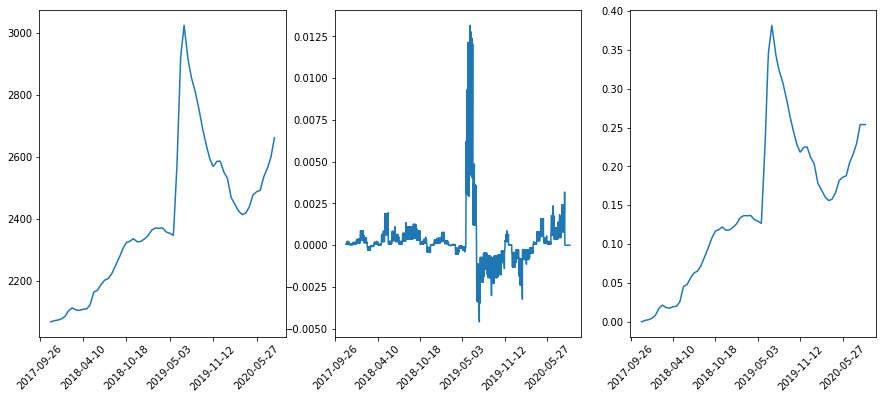

Average Weekly Hours AWHAETP


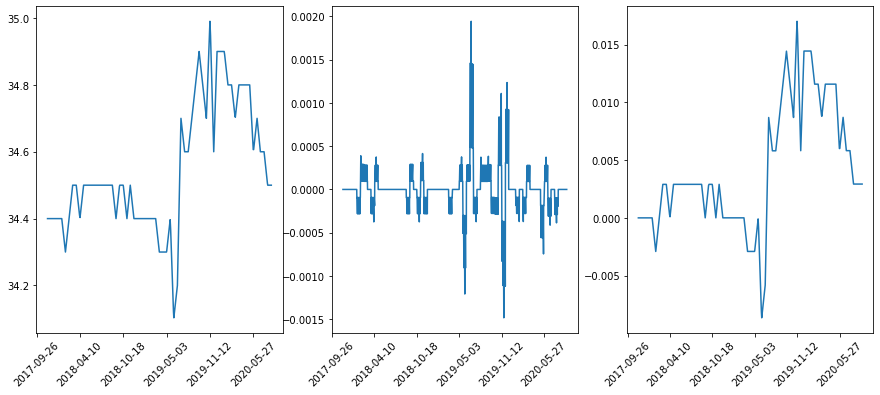

Credit to Income UMCSENT


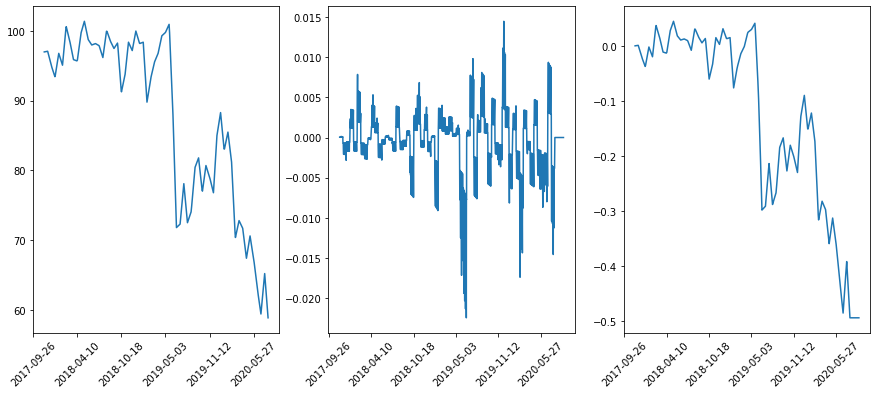

Consumer Confidence TDSP


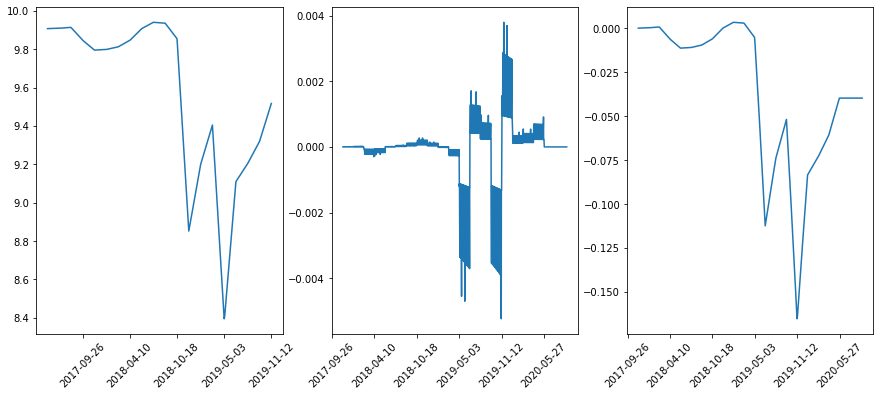

Oil Prices DCOILWTICO


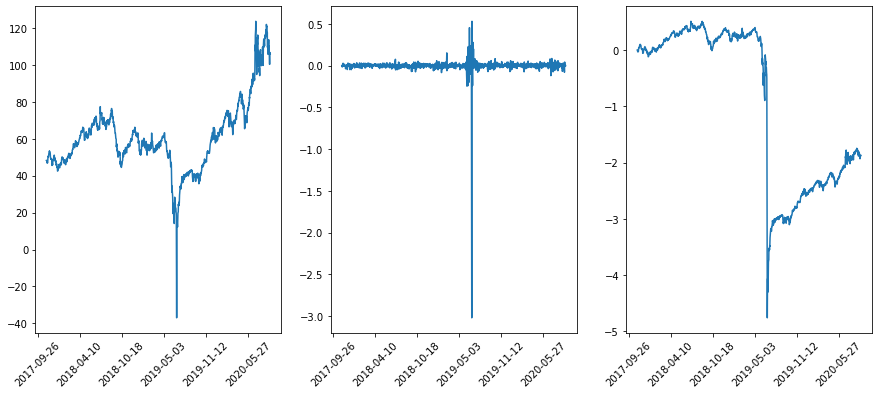

Inflation CPIAUCSL


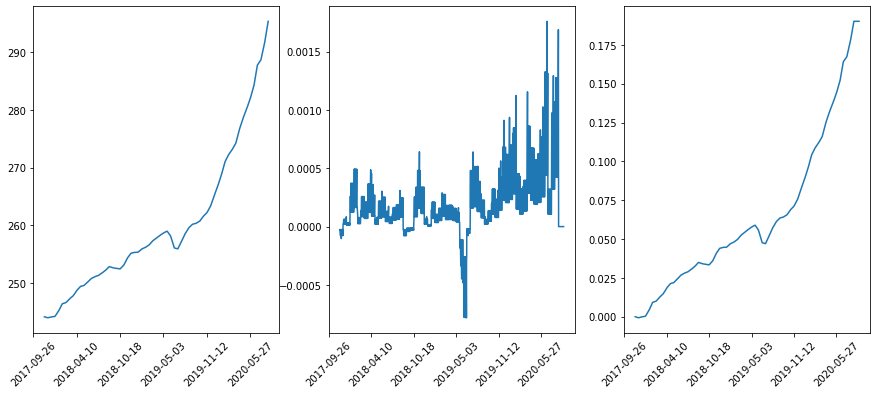

Housing Prices CSUSHPINSA


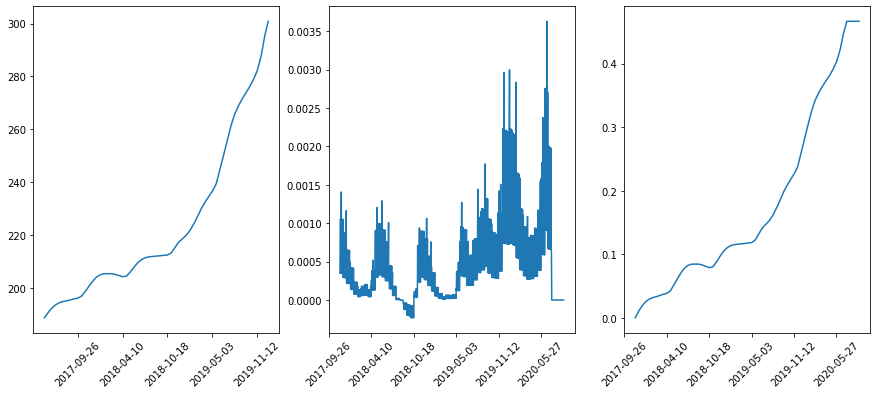

Interest Rates FEDFUNDS


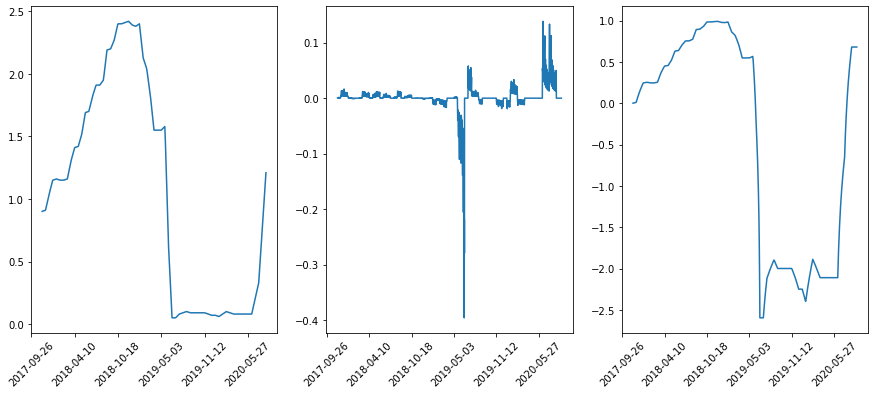

10 Year to 3 Month T10Y3M


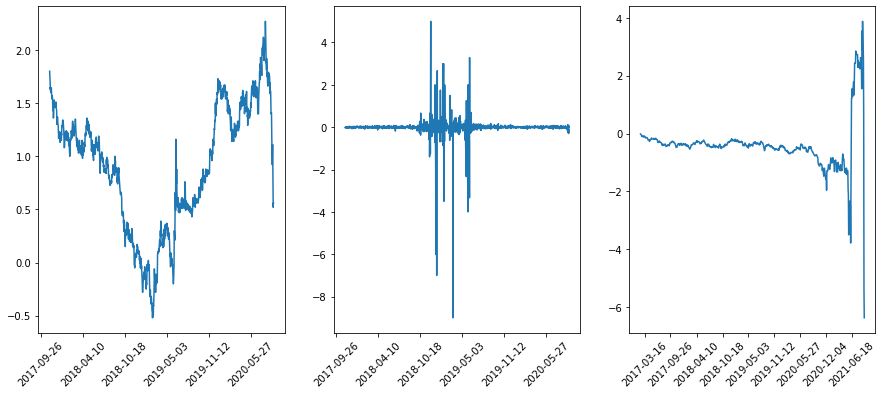

Recession Indicator USREC


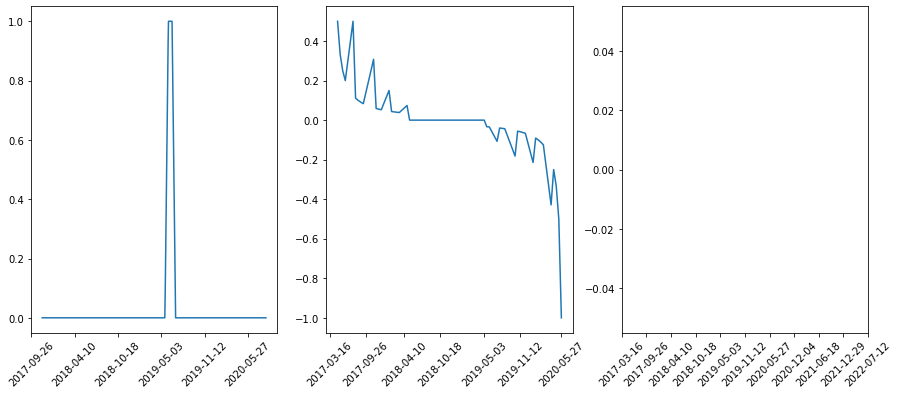

OECD Leading Indicator USALOLITONOSTSAM


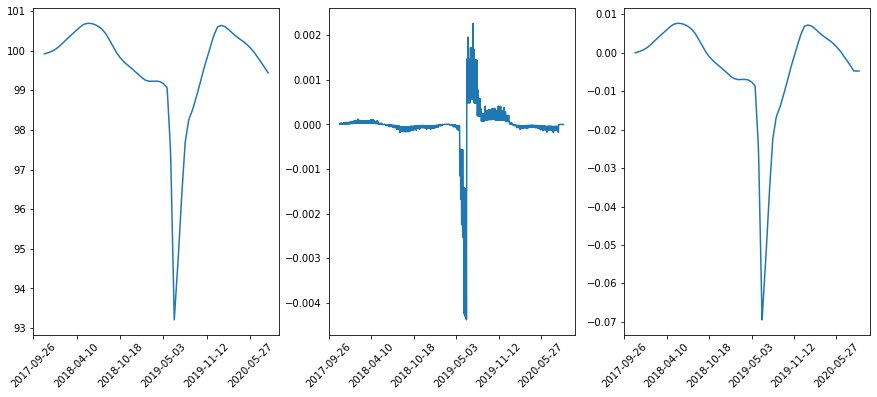

Coincident Index USPHCI


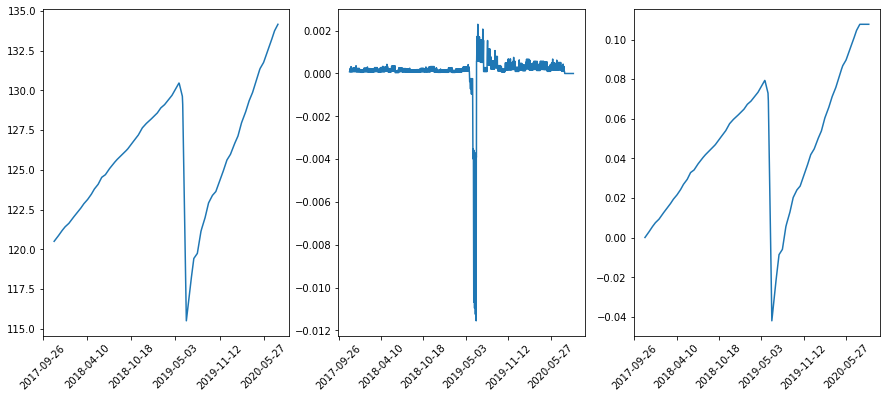

Index: Industrial Production INDPRO


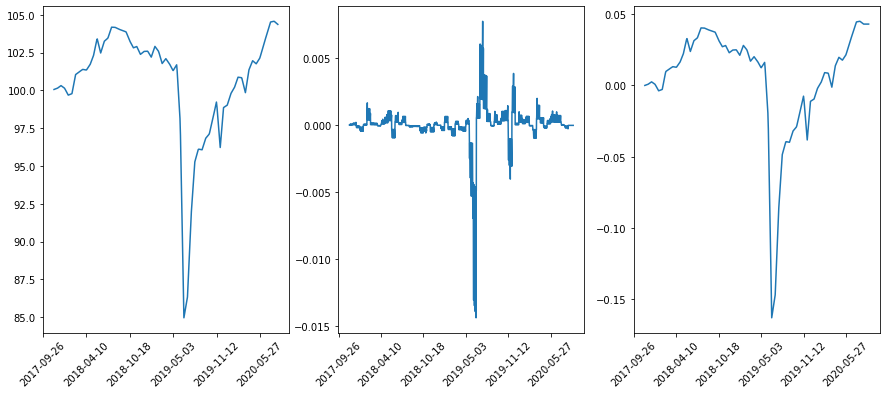

Mfr Orders Excl AC NEWORDER


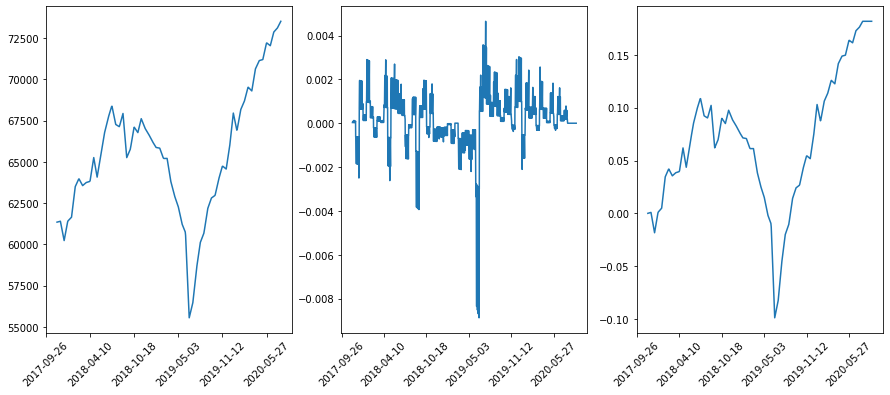

Personal Expenditures PCE


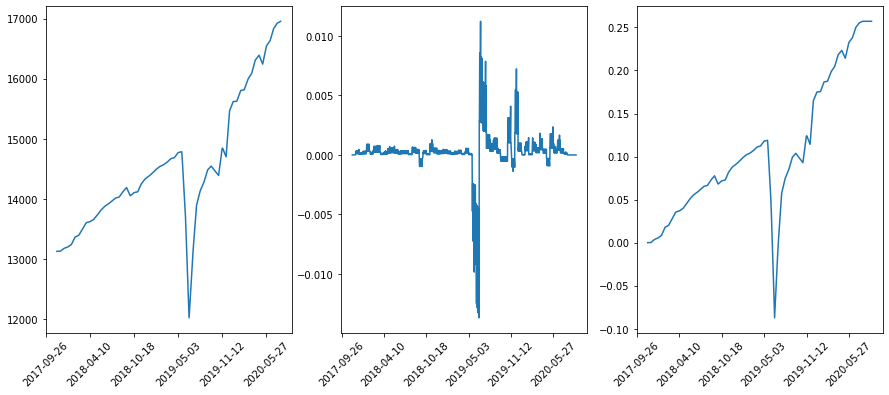

In [126]:
print('nominal,','pct_change,','pct_change().cumsum')
for pos in range(0,len(fred_names)):
    print(fred_friendly_names[pos],fred_names[pos])
    name = fred_names[pos]
    
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False,figsize=(15,6))
    ax1.plot(completed_fred_pvt_df[name])
    ax1.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
    ax2.plot(completed_fred_pvt_df[name].pct_change())
    ax2.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
    ax3.plot(completed_fred_pvt_df[name].pct_change().cumsum())
    ax3.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
    plt.show()

In [127]:
#screener['vol_30d_2yr']

In [128]:
#pd.DataFrame(np.mean(np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())[['mean','pi_lower']],axis=1)).iloc[0].values[0]
#[s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]]
#screener['Adj Close'].loc[decision_metrics_df.index]

In [129]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#tscv = expanding_window(initial =52*2, horizon = 13,period = 26)

#batchClearLimit = round(len(list__)/7)

print("adf < .05 or .01, mean reverting")
print("Hurst")
print("> .5 - The time series is mean reverting.")
print("= .5 - The time series is a Geometric Brownian Motion.")
print("< .5 - The time series is trending.")
"""*indexes['Symbol'].values,*sectors['Symbol'].values,"""
"""
widgets.Dropdown(
    #options=stocks_,
    #value=None,
    description='Choose Stock:',
    disabled=False,
)

#y_=widgets.Select(options=stocks_,disabled=False)
y_=widgets.Select(options=np.sort([*list_sector_n_indexes,*list_stocks]),value=None,disabled=False)

a=interact(plot_,symbol_=y_)
"""

adf < .05 or .01, mean reverting
Hurst
> .5 - The time series is mean reverting.
= .5 - The time series is a Geometric Brownian Motion.
< .5 - The time series is trending.


"\nwidgets.Dropdown(\n    #options=stocks_,\n    #value=None,\n    description='Choose Stock:',\n    disabled=False,\n)\n\n#y_=widgets.Select(options=stocks_,disabled=False)\ny_=widgets.Select(options=np.sort([*list_sector_n_indexes,*list_stocks]),value=None,disabled=False)\n\na=interact(plot_,symbol_=y_)\n"

In [130]:
def process_values(values):
    
    sector_list = []
    symbol_list = []
    for i in np.array(values):
        t= dict_sectors[i]
        sector_list.append(t)
        
        sublist = filtered_screener_sorted[filtered_screener_sorted['Sector Symbol']==t].index
        temp_df = filtered_screener_sorted.loc[sublist]
        #temp_df_ = temp_df['risk_trend_factor'].replace(['error','missing'], np.nan).dropna()
        
        #temp_df_filtered = temp_df_[temp_df_>0]
        
        flat_list = [item for item in temp_df.index]
        symbol_list.extend(flat_list)        
    
    button = widgets.Button(description="Process")
    output = widgets.Output()

    display(button, output)

    print("Symbols > 0 trend_factor_score")
    print(len(sector_list),sector_list)
    print(len(symbol_list),symbol_list)
    
    def on_button_clicked(b):
        with output:            
            plot_(symbol_list)

    button.on_click(on_button_clicked)    
    
y_=widgets.SelectMultiple(
    options=list(dict_sectors.keys()),
    description='Choose Sectors: ',
    disabled=False
)

a=interact(process_values,values=y_)

interactive(children=(SelectMultiple(description='Choose Sectors: ', options=('Basic Materials', 'Communicatio…

                        Sector
Healthcare                  11
Consumer Defensive          11
error                        8
Industrials                  5
Consumer Cyclical            5
Financial Services           2
Utilities                    2
Communication Services       1
Technology                   1
Energy                       1


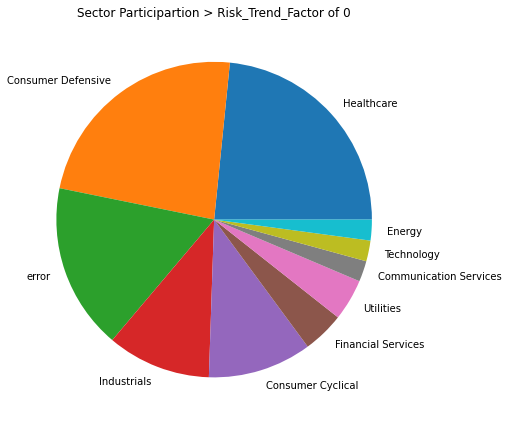

In [131]:
decision_metrics_df = pd.read_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_decision_metrics_df.csv')
decision_metrics_df.set_index(decision_metrics_df.iloc[:, 0],inplace=True)

counts_df = pd.DataFrame(decision_metrics_df['Sector'].value_counts())

print(counts_df)
fig, ax = plt.subplots()
ax.pie(counts_df['Sector'], labels=counts_df.index)
ax.set_title('Sector Participartion > Risk_Trend_Factor of 0')
plt.tight_layout()
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_piechart-sectors.png', dpi=300, format='png', bbox_inches='tight')

In [132]:

prices_pvt_wk = pd.pivot_table(prices_df, values=['Adj Close'], index=prices_df.index,columns=['Symbol']).asfreq('d').interpolate().asfreq('W-'+nyse_dates.index[-1].strftime('%a'))
prices_pvt_wk.columns = prices_pvt_wk.columns.droplevel(0)


In [133]:
from vevestaX import vevesta as v

try:
    V=v.Experiment()
    V.start()
    V.ds=decision_metrics_df
    V.fe=decision_metrics_df
    V.end()
    V.dump(techniqueUsed='fbprophet',filename='..\\reports\\'+end.strftime('%Y-%m-%d')+'_decision_metrics_df.xlsx',message="EDA-fbprophet-nested-CV",version=1)
    os.rename('EDA.pdf','..\\reports\\'+end.strftime('%Y-%m-%d')+'_decision_metrics_df.pdf')
    #os.remove('EDA.pdf')
except:
    pass

try:
    V=v.Experiment()
    V.start()
    V.ds=fred_pvt_sample
    V.fe=fred_pvt_sample
    V.end()
    V.dump(techniqueUsed='fred_data',filename='..\\reports\\'+end.strftime('%Y-%m-%d')+'_completed_fred_pvt.xlsx',message="EDA-fred",version=2)
    os.rename('EDA.pdf','..\\reports\\'+end.strftime('%Y-%m-%d')+'_completed_fred_pvt.pdf')
    
except:
    pass

try:
    V=v.Experiment()
    V.start()
    V.ds=prices_pvt_wk[filtered_screener_sorted.index]
    V.fe=prices_pvt_wk[filtered_screener_sorted.index]
    V.end()
    V.dump(techniqueUsed='price_data',filename='..\\reports\\'+end.strftime('%Y-%m-%d')+'_completed_prices_pvt_wk.xlsx',message="EDA-prices",version=3)
    os.rename('EDA.pdf','..\\reports\\'+end.strftime('%Y-%m-%d')+'_completed_prices_pvt_wk.pdf')
except:
    pass

os.remove('EDA.pdf')

Dumped the experiment in the file ..\reports\2022-07-15_decision_metrics_df.xlsx
Love VevestaX? Give us a shoutout at vevestax@vevesta.com
Dumped the experiment in the file ..\reports\2022-07-15_completed_fred_pvt.xlsx
Find the right technique for your Machine Learning project at https://www.vevesta.com?utm_source=vevestaX
Dumped the experiment in the file ..\reports\2022-07-15_completed_prices_pvt_wk.xlsx
Track evolution of Data Science projects at https://www.vevesta.com?utm_source=vevestaX for free.


In [134]:



c_df = prices_pvt_wk.corr()
c_df.sort_values(by='SPY',inplace=True,ascending=False,axis=1)
c_df.sort_values(by='SPY',inplace=True,ascending=False,axis=0)
c_df.to_csv('..\\reports\\'+end.strftime('%Y-%m-%d')+'_corr_5_yr_prices_pvt_wk.csv')